In [1]:
import os
import sys
sys.path.append('/home/fruitspec-lab/FruitSpec/Code/fsCounter')
from omegaconf import OmegaConf
import pyzed.sl as sl
import cv2
import numpy as np
from scipy.stats import gaussian_kde
import kornia as K
from tqdm import tqdm
import numpy as np
import collections
import pandas as pd
from vision.misc.help_func import get_repo_dir, scale_dets, validate_output_path, scale
from vision.depth.zed.svo_operations import get_frame, get_depth, get_point_cloud, get_dimensions, sl_get_dimensions

repo_dir = get_repo_dir()
sys.path.append(os.path.join(repo_dir, 'vision', 'detector', 'yolo_x'))

from vision.pipelines.detection_flow import counter_detection
from vision.pipelines.misc.filters import filter_by_distance, filter_by_size, filter_by_height, sort_out
from vision.tracker.fsTracker.score_func import compute_dist_on_vec
from vision.data.results_collector import ResultsCollector
from vision.tools.translation import translation as T
from vision.tools.camera import is_sturated
from vision.tools.color import get_hue
from vision.tools.video_wrapper import video_wrapper
from vision.tools.image_stitching import plot_2_imgs
import matplotlib.pyplot as plt
import seaborn as sns
import kornia as K


In [2]:
repo_dir = get_repo_dir()
pipeline_config = "/home/fruitspec-lab/FruitSpec/Code/fsCounter/vision/pipelines/config/pipeline_config.yaml"
runtime_config = "/home/fruitspec-lab/FruitSpec/Code/fsCounter/vision/pipelines/config/runtime_config.yaml"
cfg = OmegaConf.load(pipeline_config)
args = OmegaConf.load(runtime_config)

validate_output_path(args.output_folder)

In [3]:
detector = counter_detection(cfg, args)
results_collector = ResultsCollector(rotate=args.rotate)
translation = T(cfg.translation.translation_size, cfg.translation.dets_only, cfg.translation.mode)

cam = video_wrapper(args.movie_path, args.rotate, args.depth_minimum, args.depth_maximum)

# Read until video is completed
print(f'Inferencing on {args.movie_path}\n')
number_of_frames = cam.get_number_of_frames()


loading checkpoint from /home/fruitspec-lab/FruitSpec/weights/Run_6_Dec_2022_1Class_aug_tasqV2/best_ckpt.pth
loaded checkpoint done.
Inferencing on /home/fruitspec-lab/Downloads/0.5m1sts/ZED_1.svo



In [4]:
measures_path = "/home/fruitspec-lab/Downloads/0.5m1sts/output/measures.csv"
measures_frame = pd.read_csv(measures_path)

In [5]:
def plot_image_grid(images, nrows, ncols, titles=None, figsize=None, xlabels=None, ylabels=None, cmap='viridis'):
    """
    Plots a grid of images using matplotlib.

    Parameters:
    images (list): A list of numpy arrays representing the images to be plotted.
    nrows (int): The number of rows in the grid.
    ncols (int): The number of columns in the grid.
    titles (list, optional): A list of strings representing the titles of the images. Must have the same length as images.
    figsize (tuple, optional): A tuple representing the size of the figure. Defaults to (ncols * 5, nrows * 5).
    xlabels (list, optional): A list of strings representing the x-axis labels for each image. Must have the same length as images.
    ylabels (list, optional): A list of strings representing the y-axis labels for each image. Must have the same length as images.
    cmap (str, optional): The color map to use when plotting the images. Defaults to 'viridis'.

    Returns:
    None
    """
    n_images = len(images)
    if isinstance(figsize, type(None)):
        figsize = (ncols * 5, nrows * 5)
    titles, xlabels, ylabels = (np.full(n_images, "") if isinstance(titles, type(None)) else arr
                                for arr in [titles, xlabels, ylabels])
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    for i, ax in enumerate(axs.flat):
        image = images[i]
        ax.imshow(image)
        ax.set_title(titles[i])
        ax.set_xlabel(xlabels[i])
        ax.set_ylabel(ylabels[i])
    plt.tight_layout()
    plt.show()

def get_real_world_dims_with_correction(depth_map, fx = 1065.98388671875, fy = 1065.98388671875, resized = True):
    """
    calculates each pixel size based on trigo
    :param depth_map: distance_map to each point or an empty string
    :return: size for each pixel
    """
    pic_size = depth_map.shape
    if resized:
        resize_fator_x = 1080/pic_size[0]
        resize_fator_y = 1920/pic_size[1]
    else:
        resize_fator_x = 1
        resize_fator_y = 1
    x0 = pic_size[1] /2
    y0 = pic_size[0] /2
    pixel_mm = 0.002
    focal_len = (fx + fy) / 2 * pixel_mm
    x_range = np.arange(1, pic_size[1]+1)
    X_pix_dist_from_center = np.abs(np.array([x_range for i in range(pic_size[0])]) - x0)
    X_mm_dist_from_center = (X_pix_dist_from_center * (X_pix_dist_from_center+1)*(pixel_mm**2))
    beta = np.arctan(0.001/(focal_len + (X_mm_dist_from_center/focal_len)))
    gamma = np.arctan((X_pix_dist_from_center+1)*pixel_mm/focal_len)
    size_x = (np.tan(gamma) - np.tan(gamma-beta))*depth_map*2*resize_fator_x
    size_y = (np.tan(gamma) - np.tan(gamma-beta))*depth_map*2*resize_fator_y
    return size_x, size_y, size_x*size_y

def get_pix_size(depth, box, fx = 1065.98388671875, fy = 1065.98388671875,
                 pixel_mm = 0.0002, org_size = np.array([1920,1080])):
    """
    Calculates the size of a pixel in millimeters given a distance from the camera and the intrinsic parameters of the camera.

    Args:
        depth (float): The depth from the camera to the object in meters.
        box (list): ROI for pixel size int hte following format: x1,y1,x2,y2.
        fx (float): The focal length of the camera in the x direction in pixels. Default is 1065.98388671875.
        fy (float): The focal length of the camera in the y direction in pixels. Default is 1065.98388671875.
        pixel_mm (float): The size of a pixel in millimeters. Default is 0.002.
        org_size (ndarray): The size of the image in pixels. Default is np.array([1920, 1080]).

    Returns:
        size_pix (float): The size of a pixel
    """
    x1,y1,x2,y2 = box
    y0, x0 = org_size/2
    focal_len = (fx + fy) / 2 * pixel_mm
    x_range = np.arange(x1, x2+1)
    x_pix_dist_from_center = np.abs(np.array([x_range for i in range(y2-y1)]) - x0)
    x_mm_dist_from_center = (x_pix_dist_from_center * (x_pix_dist_from_center+1)*(pixel_mm**2))
    beta = np.arctan(0.001/(focal_len + (x_mm_dist_from_center/focal_len)))
    gamma = np.arctan((x_mm_dist_from_center+1)*pixel_mm/focal_len)
    size_pix = (np.tan(gamma) - np.tan(gamma-beta))*depth*2
    return size_pix


def cut_center_of_box(image, margin=0.05):
    """
    Cuts the center of the box.
    
    Args:
    - image: A 3D Numpy array representing a cropped xyz image.
    - margin: A float representing the percentage of margin to remove from the center of the image.

    Returns:
    - A 3D Numpy array representing the cropped image with the outside of the box removed.
    """
    t, l, (b, r) = 0 ,0, image.shape[:2]
    y_max, x_max = image.shape[:2]
    h_m = int((b-t)*margin)
    w_m = int((r-l)*margin)
    cut_box = image[max(0, t+h_m):min(y_max, b-h_m), max(0, l+w_m):min(x_max, r-w_m)]
    return cut_box


def xyz_center_of_box(image, method="median"):
    """
    Calculates the median or mean x, y, and z coordinates of the fruit.

    Args:
    - image: A 3D Numpy array representing a cropped xyz image.
    - method: A string representing the method to use to calculate the center of the fruit. Must be either "median" or "mean".

    Returns:
    - A tuple of floats representing the x, y, and z coordinates of the center of the fruit.
    """
    if method=="median":
        cut_box = cut_center_of_box(image, 0.025)
        x_median = np.nanmedian(cut_box[:, :, 0])
        y_median = np.nanmedian(cut_box[:, :, 1])
        z_median = np.nanmedian(cut_box[:, :, 2])
    elif method=="mean":
        cut_box = cut_center_of_box(image, 0.4)
        x_median = np.nanmean(cut_box[:, :, 0])
        y_median = np.nanmean(cut_box[:, :, 1])
        z_median = np.nanmean(cut_box[:, :, 2])
    else: # calculates only on the edge of the cut box
        cut_box = cut_center_of_box(image, 0.25).copy()
        if cut_box.shape[0] > 10 and cut_box.shape[1] > 10:
            cut_box[5:-5,5:-5] = np.nan
        x_median = np.nanmedian(cut_box[:, :, 0])
        y_median = np.nanmedian(cut_box[:, :, 1])
        z_median = np.nanmedian(cut_box[:, :, 2])
    return x_median, y_median, z_median


def dist_to_box_center(image, method="median"):
    """
    Calculates the distance from the camera to the center of the fruit.

    Args:
    - image: A 3D Numpy array representing a cropped xyz image.
    - method: A string representing the method to use to calculate the center of the fruit. Must be either "median" or "mean".

    Returns:
    - A float representing the distance from the camera to the center of the fruit.
    """
    return np.sum(np.array(list(xyz_center_of_box(image, method)))**2)

def depth_to_box_center(image, method="median"):
    """
    Calculates the depth from the camera to the center of the fruit.

    Args:
    - image: A 3D Numpy array representing a cropped xyz image.
    - method: A string representing the method to use to calculate the center of the fruit. Must be either "median" or "mean".

    Returns:
    - A float representing the depth from the camera to the center of the fruit.
    """
    return xyz_center_of_box(image, method)[2]

def get_dims_w_pixel_size(pc_img, box, center_method="median"):
    """
    Calculates the width and height of a 2D bounding box in millimeters, based on the pixel size of the image.

    Args:
    - pc_img: A 3D Numpy array representing a point cloud image.
    - box: A tuple of integers representing the (x1, y1, x2, y2) coordinates of the bounding box.
    - center_method: A string representing the method to use to calculate the center of the fruit. Must be either "median" or "mean".

    Returns:
    - A tuple of floats representing the width and height of the bounding box in millimeters.
    """
    dist = depth_to_box_center(pc_img, center_method)
    size_pix = get_pix_size(dist, box)
    width = np.mean(np.sum(size_pix,axis = 0))
    height = np.mean(np.sum(size_pix,axis = 1))
    return width, height 

def hue_filtering(rgb_crop, nstds = 1):
    """
    Apply hue filtering to an RGB image crop.

    Parameters:
        rgb_crop (numpy.ndarray): Input RGB image crop as a numpy array.
        nstds (float): Number of standard deviations used to determine the upper and lower hue thresholds.
    
    Returns:
        numpy.ndarray: mask where True value indicated what was filtered out
    """
    rgb_c = rgb_crop.copy()
    hsv = cv2.cvtColor(rgb_c, cv2.COLOR_BGR2HSV)
    hue, sat, v = cv2.split(hsv.copy())
    hist_vals, hist_bins = np.histogram(hue, bins = 50)
    mode = hist_bins[np.argmax(hist_vals)]
    if mode > 35: # greener area
        nstds *= 1.5
    hue_std = np.std(hue)
    upper_limit = mode + nstds*hue_std
    lower_limit = mode - nstds*hue_std
    logical_vec = np.any([hue > upper_limit, hue < lower_limit], axis = 0)
    return logical_vec

In [6]:
def get_track_id_frames(measures_frame, track_id):
    """
    Returns a numpy array of frames associated with a given track ID.

    Parameters:
    measures_frame (pandas.DataFrame): A dataframe containing measurements data.
    track_id (int): The ID of the track to retrieve frames for.

    Returns:
    numpy.ndarray: A 1-dimensional array of frames associated with the given track ID.
    """
    return measures_frame[measures_frame["track_id"] == track_id]["frame"].values

def get_track_id_boxes(measures_frame, track_id):
    """
    Returns a numpy array of bounding boxes associated with a given track ID.

    Parameters:
    measures_frame (pandas.DataFrame): A dataframe containing measurements data.
    track_id (int): The ID of the track to retrieve bounding boxes for.

    Returns:
    numpy.ndarray: A 2-dimensional array of bounding boxes associated with the given track ID.
        Each row contains the x1, y1, x2, y2 coordinates of a bounding box in the format [x1, y1, x2, y2].
    """
    return measures_frame[measures_frame["track_id"] == track_id][["x1", "y1", "x2", "y2"]].values

def validate_bbox(crop, rgb_img):
    """
    Validates the given bounding box coordinates and ensures that they fall within the dimensions of the RGB image.

    Parameters:
    crop (tuple): A tuple containing the coordinates of the bounding box in the format (x1, y1, x2, y2).
        x1 and y1 are the coordinates of the top-left corner of the bounding box, and x2 and y2 are the coordinates of the bottom-right corner.
    rgb_img (numpy.ndarray): A numpy array representing the RGB image.

    Returns:
    tuple: A tuple containing the validated bounding box coordinates in the format (x1, y1, x2, y2).
        The returned coordinates ensure that the bounding box falls entirely within the dimensions of the RGB image.
    """
    x1, y1, x2, y2 = crop
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    h, w = rgb_img.shape[:2]
    x2 = min(x2, w-1)
    y2 = min(y2, h-1)
    return x1, y1, x2, y2


def get_track_id_images(measures_frame, track_id, args):
    cam = video_wrapper(args.movie_path, args.rotate, args.depth_minimum, args.depth_maximum)
    frame_numbers = get_track_id_frames(measures_frame, track_id)
    boxes = get_track_id_boxes(measures_frame, track_id)
    rgb_images, pc_images = [], []
    for i in tqdm(range(len(frame_numbers))):
        frame, crop = frame_numbers[i], boxes[i]
        rgb_img, _, pc_img = cam.get_zed(frame)
        x1,y1,x2,y2 = validate_bbox(crop, rgb_img)
        rgb_images.append(rgb_img[y1:y2,x1:x2])
        pc_images.append(pc_img[y1:y2,x1:x2])
    cam.close()
    return rgb_images, pc_images

def kde_filtering(centers, thresh=0.5):
    """
    Applies a Kernel Density Estimation (KDE) filtering on a set of 3D points.

    Args:
        centers (np.ndarray): A numpy array of shape (n, 3) representing the 3D coordinates of the points to filter.
        thresh (float): A threshold value to filter out points with low density. Default is 0.5.

    Returns:
        np.ndarray: A numpy array of shape (n, 3) where each filtered 3D points is replaced with np.nan
    """
    finite_logical = np.all(np.isfinite(centers), axis=1)
    if not sum(finite_logical):
        return centers
    finite_centers = centers[finite_logical].copy()
    kernel = gaussian_kde(finite_centers.T)
    points_density = np.full(len(centers), np.nan)
    points_density[finite_logical] = kernel(finite_centers.T)
    points_density = points_density/np.nansum(points_density)
    filtered_center = centers.copy()
    filtered_center[points_density <thresh/ len(finite_logical)] = np.nan
    return filtered_center

In [7]:
# rgb_images, pc_images = get_track_id_images(measures_frame, 7)
# plot_2_imgs(rgb_images[0], pc_images[0][:,:,2])

In [8]:
# for track_id in [6,7,8,28]:
#     print(track_id)
#     frame_numbers = get_track_id_frames(measures_frame, track_id)
#     boxes = get_track_id_boxes(measures_frame, track_id)
#     rgb_images, pc_images = [], []
#     for frame, crop in tqdm(zip(frame_numbers, boxes)):
#         rgb_img, _, pc_img = cam.get_zed(frame)
#         x1,y1,x2,y2 = validate_bbox(crop, rgb_img)
#         rgb_images.append(rgb_img[y1:y2,x1:x2])
#         pc_images.append(pc_img[y1:y2,x1:x2])
#     plot_image_grid(rgb_images,5,5)

In [9]:
def filter_xyz_outliers(crop, nstd=2, as_points=True):
    """
    Filters out the outliers from the 3D points in the given crop.

    Args:
        crop (ndarray): A numpy array of shape (height, width, 3) containing the 3D points.
        nstd (float): The number of standard deviations to consider for defining the range of valid values.
        as_points (bool): Whether to return the filtered 3D points as an array of points or as an array of the same shape
            as the input crop.

    Returns:
        ndarray: A numpy array of filtered 3D points. If as_points is True, this is a numpy array of shape (n, 3),
            where n is the number of valid 3D points. Otherwise, it is a numpy array of the same shape as the input crop.
    """
    centers = crop.reshape(-1, 3)
    filtered_center = centers.copy()
    for channel in [0, 1, 2]:
        channel_vals = centers[:, channel]
        val_std = np.nanstd(channel_vals)
        med_val = np.nanmedian(channel_vals)
        max_val = med_val + nstd * val_std
        min_val = med_val - nstd * val_std
        filtered_center[channel_vals > max_val] = np.nan
        filtered_center[channel_vals < min_val] = np.nan
    if as_points:
        return filtered_center
    return filtered_center.reshape(crop.shape)


def ellipsoid_fit(filtered_center):
    """
    Fits an ellipsoid to a set of 3D points using least squares estimation.

    Args:
    - filtered_center (numpy array): An N x 3 array of N 3D points in the form (x, y, z).

    Returns:
    - radius (float): The radius of the fitted ellipsoid.
    - semi_axis_1 (float): The length of the semi-major axis of the ellipsoid.
    - semi_axis_2 (float): The length of the semi-intermediate axis of the ellipsoid.
    - semi_axis_3 (float): The length of the semi-minor axis of the ellipsoid.
    """
    filtered_center[np.abs(filtered_center) > 2] = np.nan
    A = np.column_stack([filtered_center, np.ones(len(filtered_center))])
    good_rows = np.all(np.isfinite(A), axis=1)
    A = A[good_rows]

    #   Assemble the f matrix
    f = np.zeros((len(A),1))
    f[:,0] = np.sum(A[:,:3]**2, axis = 1)
    C, residules, rank, singval = np.linalg.lstsq(A,f)
    C = np.abs(C)
    #   solve for the radius
    t = (C[0]*C[0])+(C[1]*C[1])+(C[2]*C[2])+C[3]
    radius = np.sqrt(t)
    # channels are switched
    return radius, np.sqrt(C[1]), np.sqrt(C[0]), np.sqrt(C[2])

In [10]:
from sklearn.linear_model import RANSACRegressor
def ellipsoid_fit_ransac(filtered_center, num_iterations=100, inlier_threshold=0.1):
    """
    Fits an ellipsoid to a set of 3D points using RANSAC.

    Args:
    - filtered_center (numpy array): An N x 3 array of N 3D points in the form (x, y, z).
    - num_iterations (int): The number of iterations to run RANSAC for.
    - inlier_threshold (float): The maximum distance from a point to the fitted ellipsoid to be considered an inlier.

    Returns:
    - radius (float): The radius of the fitted ellipsoid.
    - semi_axis_1 (float): The length of the semi-major axis of the ellipsoid.
    - semi_axis_2 (float): The length of the semi-intermediate axis of the ellipsoid.
    - semi_axis_3 (float): The length of the semi-minor axis of the ellipsoid.
    """
    filtered_center[np.abs(filtered_center) > 2] = np.nan
    A = np.column_stack([filtered_center, np.ones(len(filtered_center))])
    good_rows = np.all(np.isfinite(A), axis=1)
    A = A[good_rows]
    if len(A) < 5:
        return np.nan, np.nan, np.nan, np.nan
    f = np.zeros((len(A),1))
    f[:,0] = np.sum(A[:,:3]**2, axis = 1)

    model = RANSACRegressor(estimator=None, residual_threshold=inlier_threshold, max_trials=num_iterations)
    model.fit(A,f)

    # Extract the coefficients of the fitted ellipsoid
    coef = model.estimator_.coef_[0]
    C = np.abs(np.concatenate([coef[:3], [1], coef[3:]]))

    #   solve for the radius
    t = (C[0]*C[0])+(C[1]*C[1])+(C[2]*C[2])+C[3]
    radius = np.sqrt(t)

    # channels are switched
    return radius, np.sqrt(C[1]), np.sqrt(C[0]), np.sqrt(C[2]) 

def get_width(crop, margin=0.2, fixed_z=True, max_z=1):
    h, w, c = crop.shape
    marginy = np.round(margin / 2 * h).astype(np.int16)
    crop_marg = crop[marginy:-marginy, :, :]
    crop_marg[crop_marg[:, :, 2] > max_z] = np.nan
    vec = np.nanmean(crop_marg, axis=0)
    vec = vec[np.isfinite(vec[:, 2])]
    if len(vec) < 2:
        return np.nan
    if fixed_z:
        width = np.sqrt(np.sum((vec[0, :-1] - vec[-1, :-1]) ** 2)) * 1000
    else:
        width = np.sqrt(np.sum((vec[0, :] - vec[-1, :]) ** 2)) * 1000
    return width


def get_height(crop, margin=0.2, fixed_z=True, max_z=1):
    h, w, c = crop.shape
    marginx = np.round(margin / 2 * w).astype(np.int16)
    crop_marg = crop[:, marginx:-marginx, :]
    crop_marg[crop_marg[:, :, 2] > max_z] = np.nan
    vec = np.nanmean(crop_marg, axis=1)
    vec = vec[np.isfinite(vec[:, 2])]
    if len(vec) < 2:
        return np.nan
    if fixed_z:
        height = np.sqrt(np.sum((vec[0, :-1] - vec[-1, :-1]) ** 2)) * 1000
    else:
        height = np.sqrt(np.sum((vec[0, :] - vec[-1, :]) ** 2)) * 1000
    return height

def get_cropped_point_cloud(bbox, point_cloud, margin=0.2):
    crop = point_cloud[max(int(bbox[1]), 0):int(bbox[3]), max(int(bbox[0]), 0): int(bbox[2]), :-1].copy()
    return crop

  8%|███████████████▏                                                                                                                                                                          | 14/172 [00:02<00:26,  6.06it/s]/tmp/ipykernel_10834/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:25<00:00,  6.62it/s]


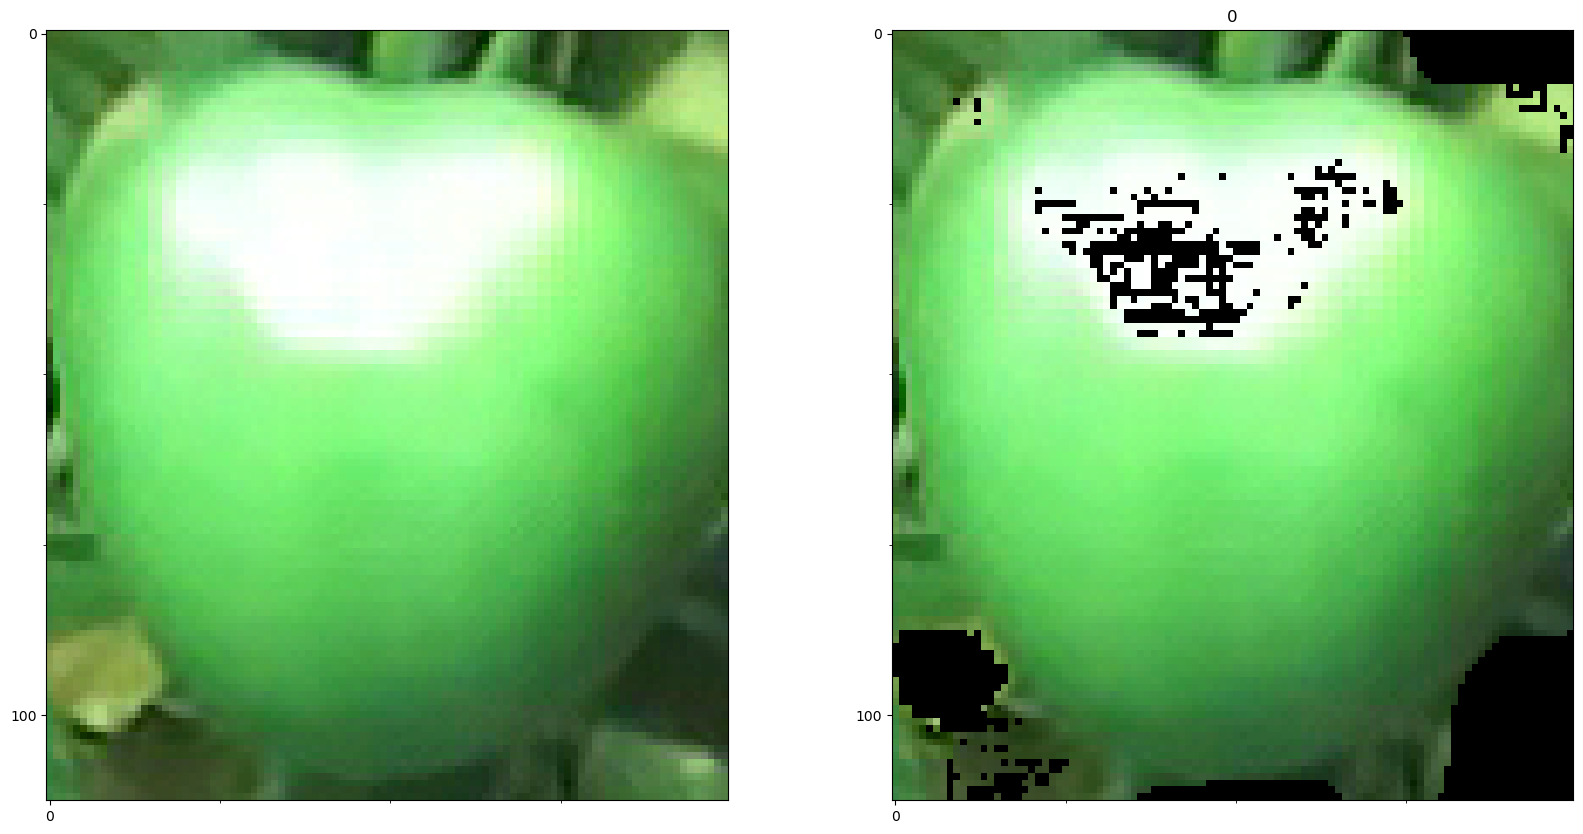

/tmp/ipykernel_10834/290486816.py:72: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_10834/290486816.py:73: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_10834/290486816.py:74: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 61.753612091094936 0.9807933487092694 55.92628584749764 0.7961533165306603 
 pix med: 
 72.23632638116698 1.5159525367226854 65.42043796662368 1.3263224779868543 
 margin 0.2: 
 48.64713027640138 0.5957890085942431 49.61948365319607 1.8592898105773197 
 margin 0.5: 
 48.32653289790763 0.6204626808728474 49.5985510087637 1.6856944281163388 
 margin 0.8: 
 48.31255864092084 0.6338622868939104 47.235132671546104 2.5779059810685103 
 margin_f0.2: 
 48.51403780454813 0.7524884264442965 50.70669498554496 1.7971900290357155 
 margin 0.5_f: 
 48.35958839502445 0.6260215570173481 50.22352799599947 1.5125632210124467 
 margin 0.8_f: 
 48.312532455595424 0.6338613917957184 47.960536272893115 1.6850060442567116


  0%|                                                                                                                                                                                                   | 0/172 [00:00<?, ?it/s]/tmp/ipykernel_10834/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
/tmp/ipykernel_10834/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:26<00:00,  6.54it/s]


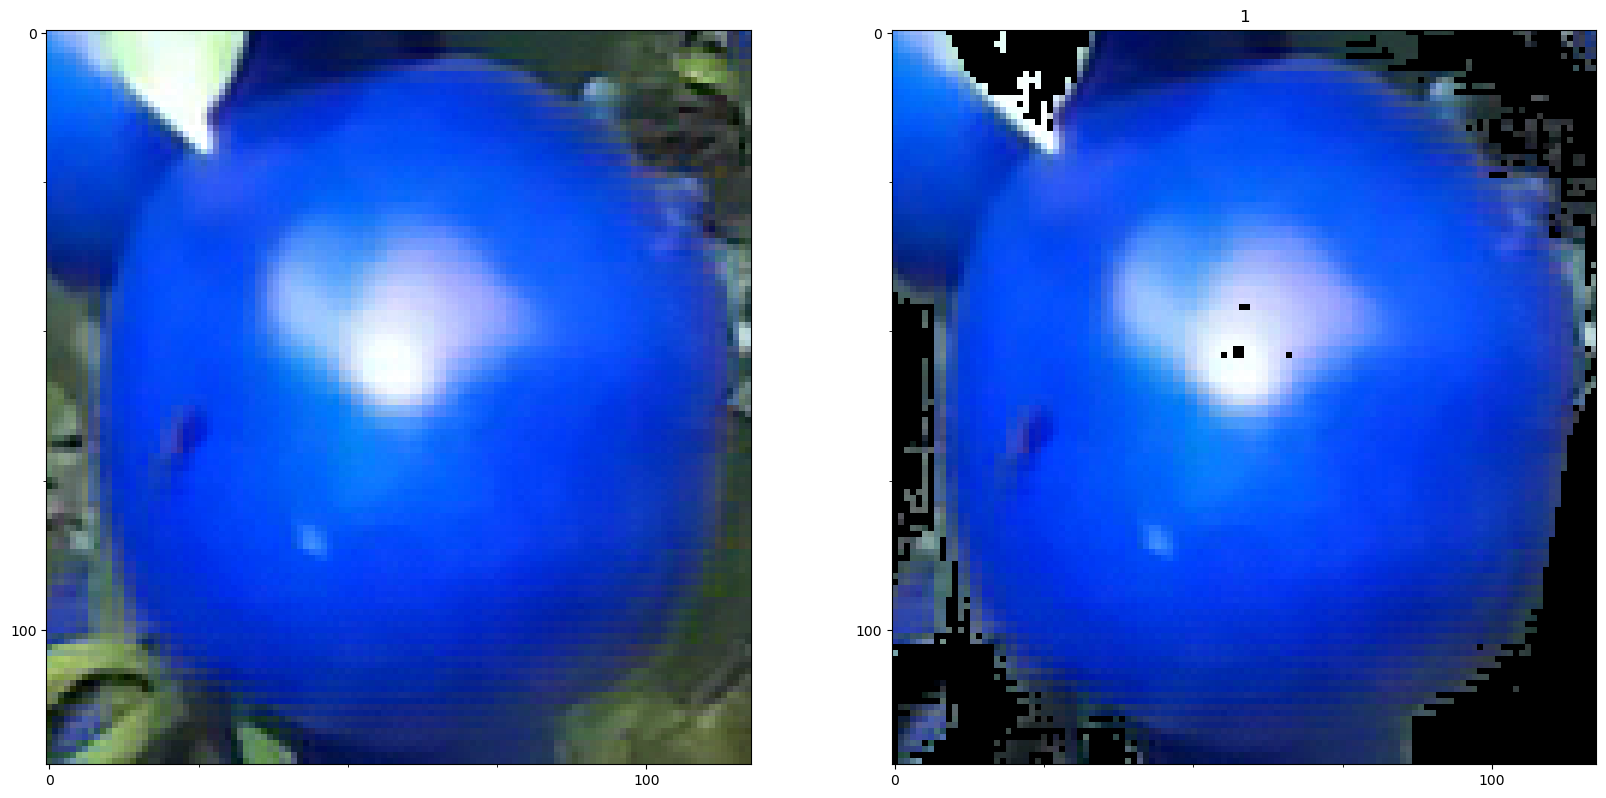

/tmp/ipykernel_10834/290486816.py:72: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_10834/290486816.py:73: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_10834/290486816.py:74: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 65.70173796184511 1.664785531685647 62.96177662152249 2.6761929390638413 
 pix med: 
 76.87236718262726 2.7630920761336566 73.67975382023022 3.9050537928830074 
 margin 0.2: 
 62.38884903317274 9.608081396316479 62.76198788437733 1.7507502211137154 
 margin 0.5: 
 63.83147149151841 14.854028521051271 63.383201180502425 1.6406966993778318 
 margin 0.8: 
 64.21914499599573 15.769832864850223 63.654219428467194 1.530297292546129 
 margin_f0.2: 
 61.748509122015435 4.279384966271189 63.54552752143422 1.6566133913120982 
 margin 0.5_f: 
 61.35269730936649 4.543664657919214 63.65705805635729 1.6282640941664572 
 margin 0.8_f: 
 60.49040206816307 4.848444714685633 63.49871801429017 1.547035281263532


  0%|                                                                                                                                                                                                   | 0/171 [00:00<?, ?it/s]/tmp/ipykernel_10834/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
/tmp/ipykernel_10834/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 171/171 [00:27<00:00,  6.33it/s]


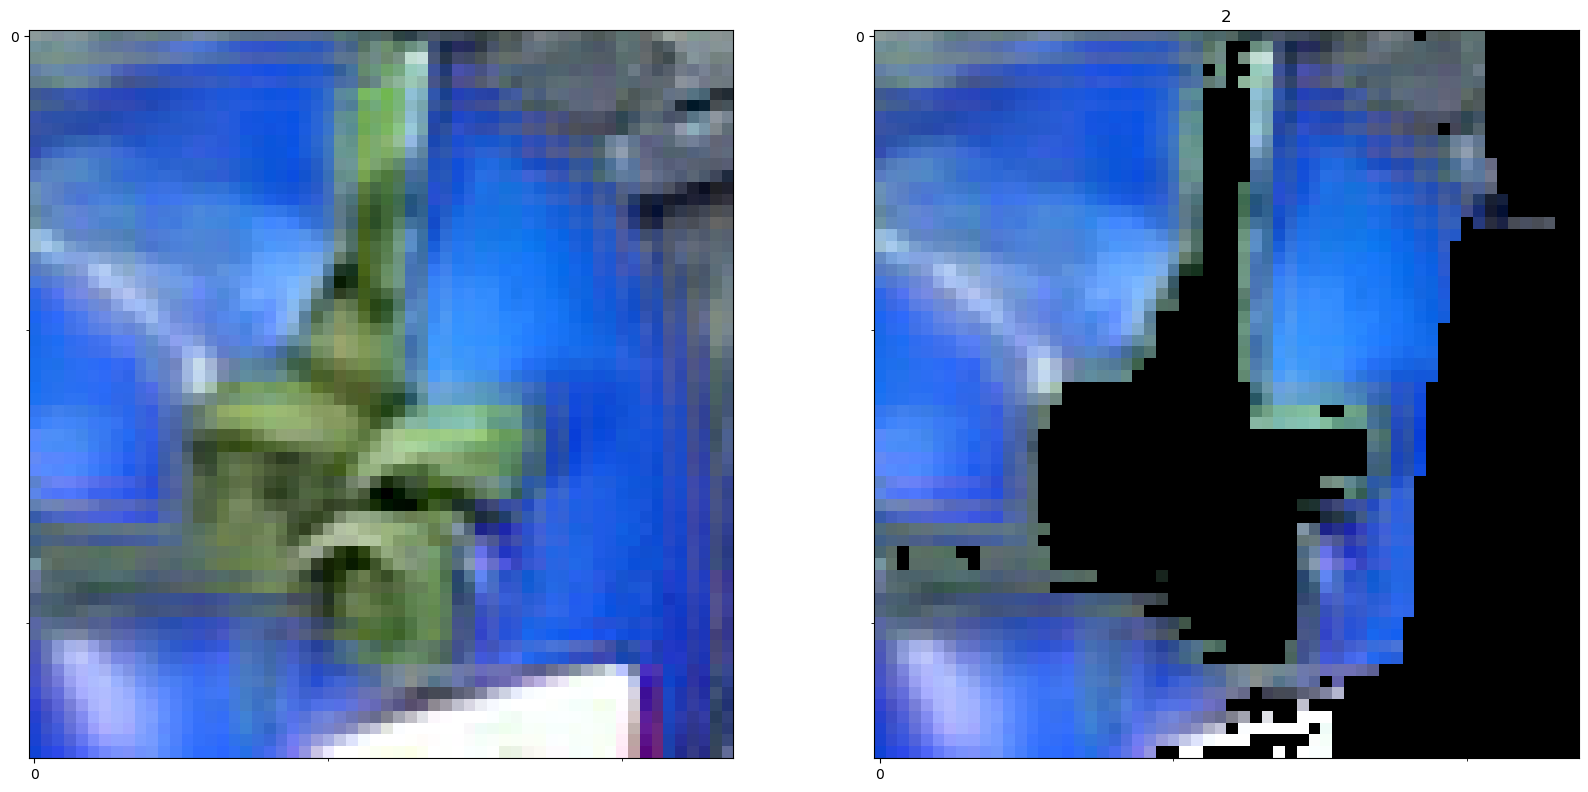

/tmp/ipykernel_10834/290486816.py:72: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_10834/290486816.py:73: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_10834/290486816.py:74: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 37.50582097797243 4.889669531546761 37.7194908790659 4.641056799381485 
 pix med: 
 43.86994408647429 5.771986458930374 44.07408200561541 5.088299652779883 
 margin 0.2: 
 63.010063327369636 21.73171906182824 69.07598998354018 44.68639897782133 
 margin 0.5: 
 84.53099832635874 18.154710850680534 64.92011596541307 47.11419702289097 
 margin 0.8: 
 84.98502686096911 16.21553081059064 60.02337163673681 47.10937732595806 
 margin_f0.2: 
 66.40076726587893 22.111326966264667 58.37601973887598 28.340914236085272 
 margin 0.5_f: 
 76.44709570017474 16.70509507172323 54.3854131161818 29.248581904601373 
 margin 0.8_f: 
 75.3572313169464 15.022411919877104 45.03176781779144 24.65362608003328


  3%|██████▌                                                                                                                                                                                    | 6/172 [00:00<00:22,  7.45it/s]/tmp/ipykernel_10834/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:25<00:00,  6.64it/s]


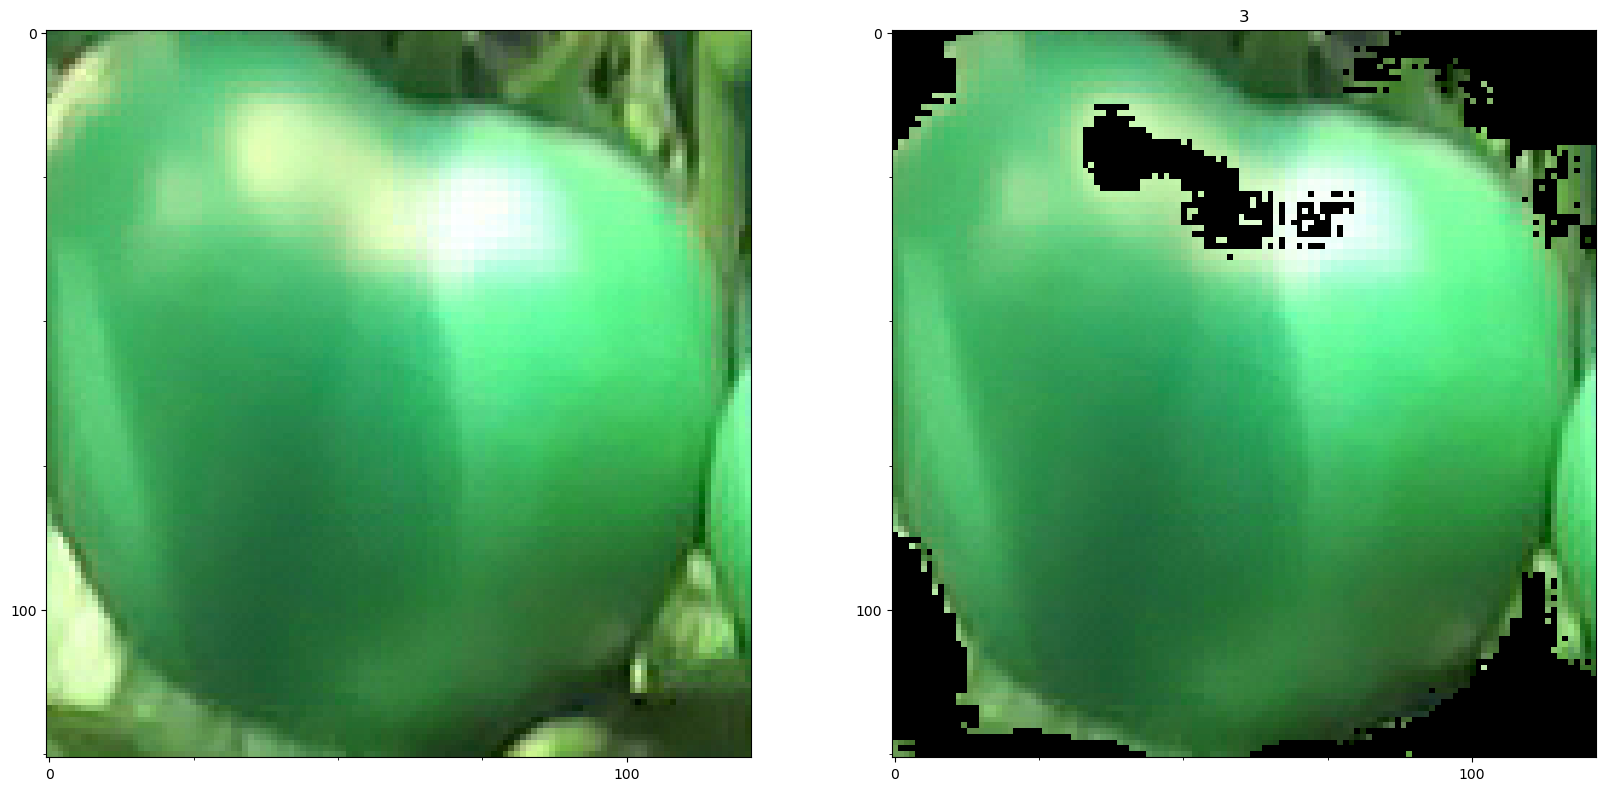

/tmp/ipykernel_10834/290486816.py:72: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_10834/290486816.py:73: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_10834/290486816.py:74: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 69.36980013853047 1.1060666736410893 66.10367347302474 1.9089588242391309 
 pix med: 
 81.14108364363948 1.4842641442834548 77.34307833507812 2.9991110005609403 
 margin 0.2: 
 56.8396208677874 2.9779398682829257 45.000141204962894 0.7254992698617406 
 margin 0.5: 
 55.088248342102354 2.1989250219213274 45.293600601685604 0.6223695769777946 
 margin 0.8: 
 54.76553023381289 2.027665287353385 45.49038113463064 0.5949762068861769 
 margin_f0.2: 
 54.78542133472686 2.108810589559354 45.714954434092654 1.0828391191360913 
 margin 0.5_f: 
 54.798813883301825 2.1089305771120204 45.80636757837478 0.8604011730995222 
 margin 0.8_f: 
 54.76533164551785 2.0272548756562636 45.798102437063704 0.7308462488588436


  0%|                                                                                                                                                                                                   | 0/151 [00:00<?, ?it/s]/tmp/ipykernel_10834/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
  7%|████████████▎                                                                                                                                                                             | 10/151 [00:01<00:21,  6.53it/s]/tmp/ipykernel_10834/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:23<00:00,  6.55it/s]


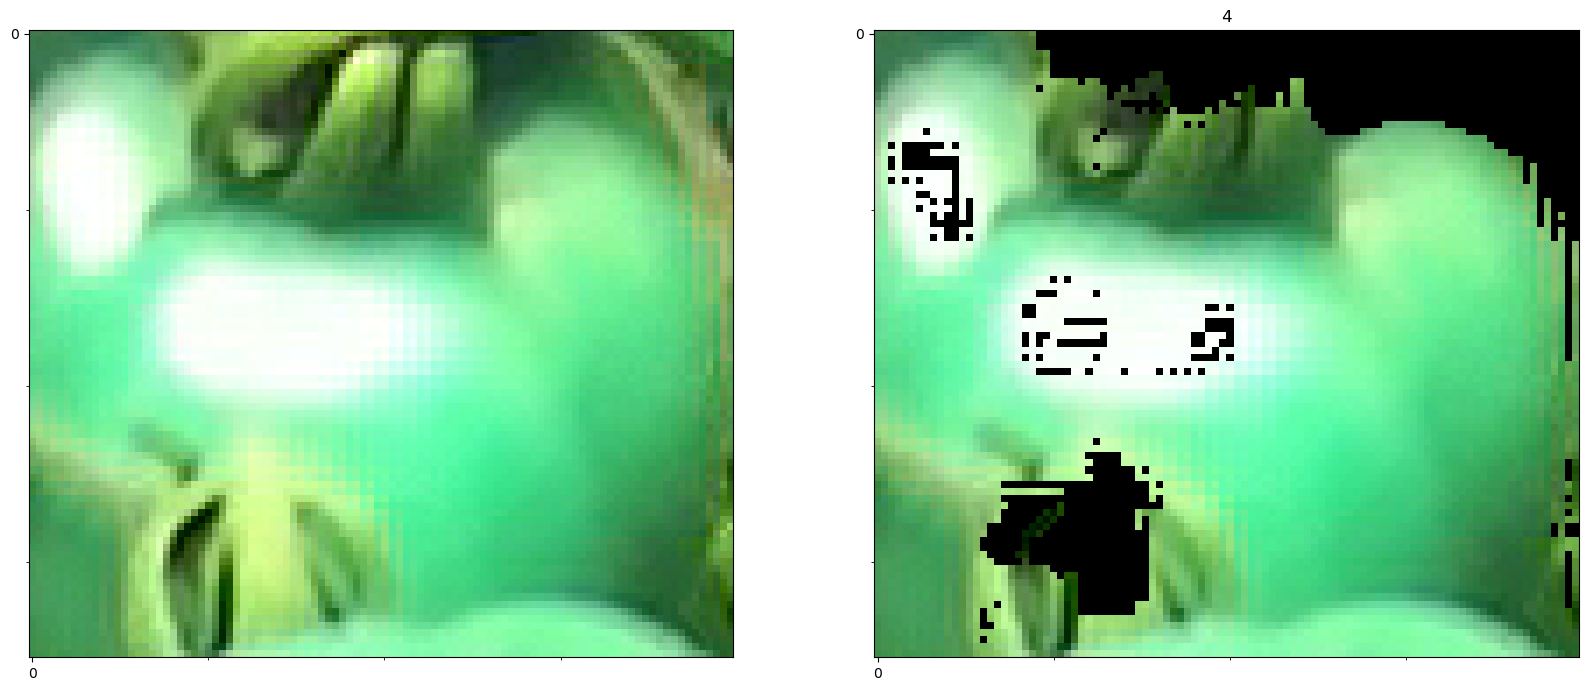

/tmp/ipykernel_10834/290486816.py:72: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_10834/290486816.py:73: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_10834/290486816.py:74: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 47.23755309698507 1.847725341367199 52.44187157016485 2.9337115808711527 
 pix med: 
 55.38765067934021 2.816335745070027 61.487171610941246 3.944596584934221 
 margin 0.2: 
 67.02480077842213 45.928715057796765 101.7172041022225 58.72197771410603 
 margin 0.5: 
 70.01968423854436 52.42835047781777 141.22428592072418 78.82534096653328 
 margin 0.8: 
 67.24434316355661 54.74776045344631 206.06186075617146 91.42397469191384 
 margin_f0.2: 
 46.94746918236183 6.538747024445453 57.3447338052538 15.205800724374742 
 margin 0.5_f: 
 47.410874251300925 7.2838653139026714 66.28321135873037 18.419309194243425 
 margin 0.8_f: 
 48.14532761838262 8.957420761209193 79.9585994801774 24.035199833893145


  0%|                                                                                                                                                                                                   | 0/106 [00:00<?, ?it/s]/tmp/ipykernel_10834/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
/tmp/ipykernel_10834/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:15<00:00,  6.93it/s]


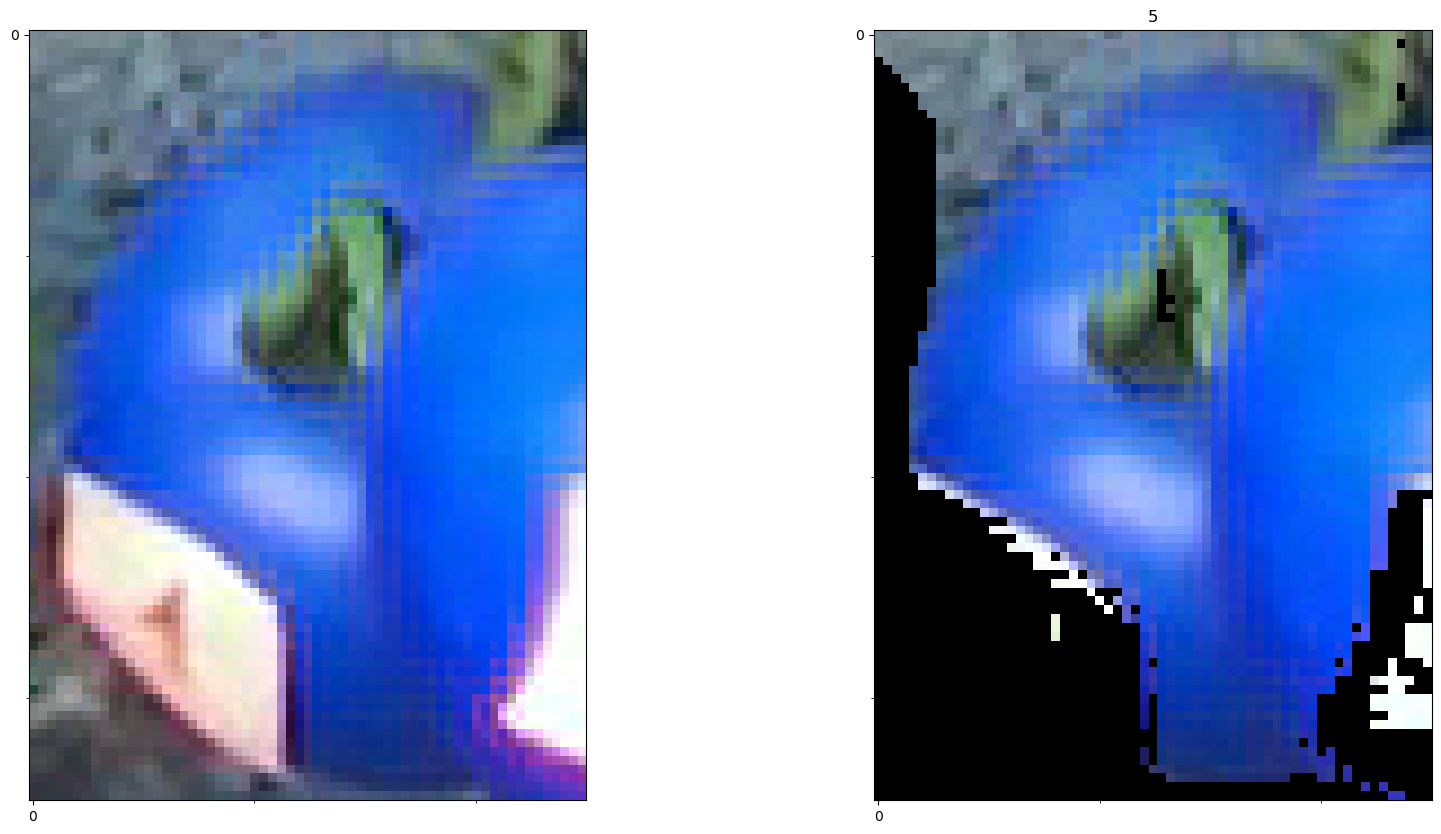

/tmp/ipykernel_10834/290486816.py:72: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_10834/290486816.py:73: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_10834/290486816.py:74: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 43.326433954033455 4.356689786073547 36.24127048456364 4.976071089312077 
 pix med: 
 50.635411147662005 5.132002546027687 42.35738085308623 5.875787104854583 
 margin 0.2: 
 99.44361667939515 37.240623650360604 96.66223001648795 55.330145626816304 
 margin 0.5: 
 101.50263818718915 38.68335145839249 104.07254809759698 58.764479126676164 
 margin 0.8: 
 103.17471279007084 38.76469042676775 105.78039819198959 58.96201061352417 
 margin_f0.2: 
 85.95139942711816 26.37622456118107 79.91594448685646 34.35162390073229 
 margin 0.5_f: 
 85.9252487151128 26.28203652469273 83.66672986380334 35.568125775081555 
 margin 0.8_f: 
 85.9642750144286 26.37337154679401 85.27631618363678 37.939693264329684


  4%|████████▎                                                                                                                                                                                  | 6/136 [00:00<00:18,  7.04it/s]/tmp/ipykernel_10834/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:20<00:00,  6.48it/s]


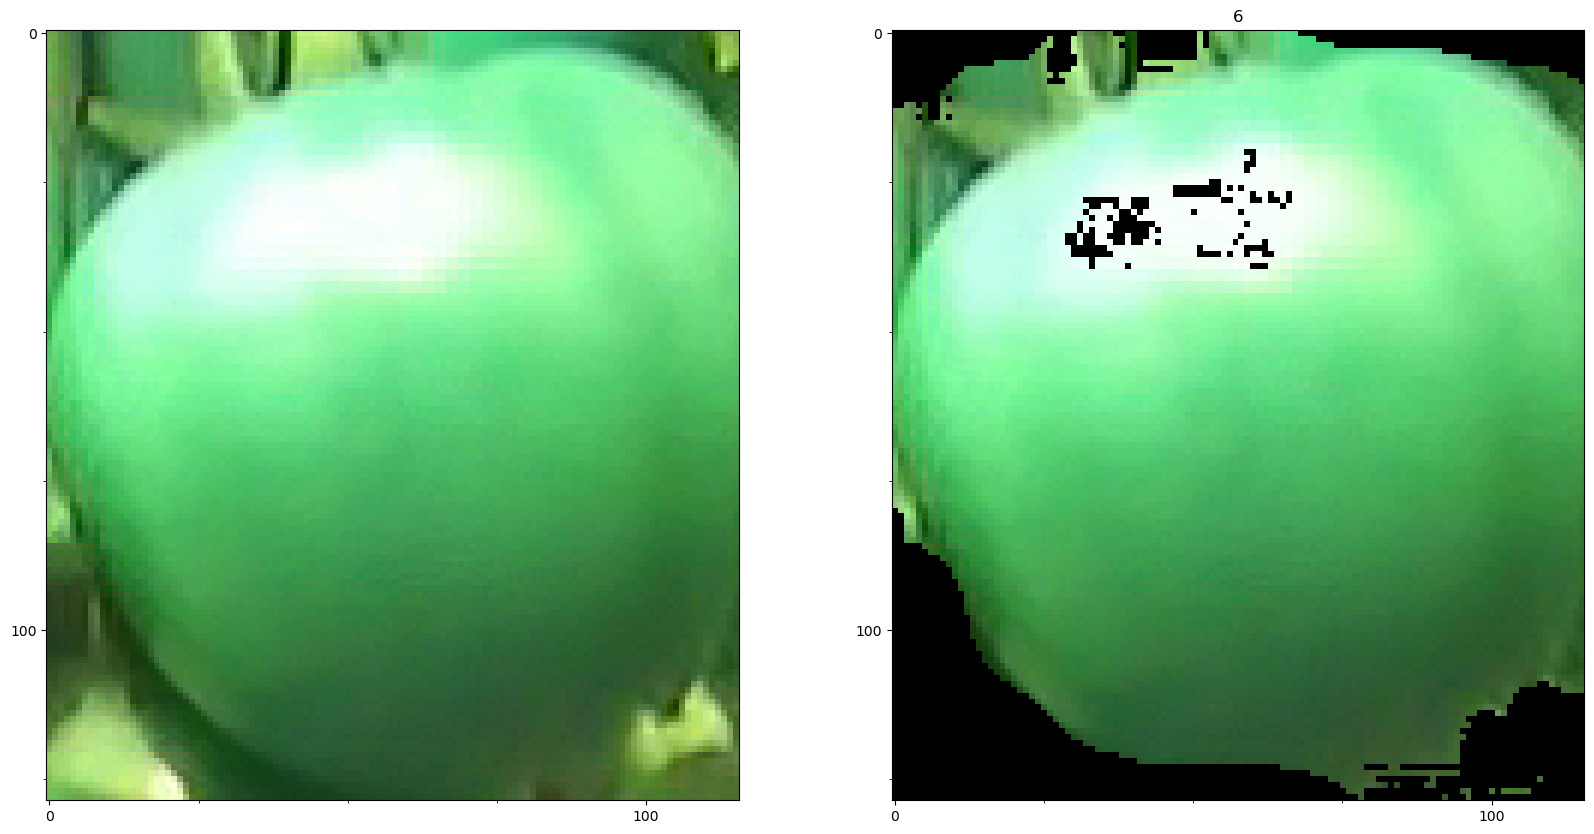

/tmp/ipykernel_10834/290486816.py:72: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_10834/290486816.py:73: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_10834/290486816.py:74: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 72.64949920702117 1.886137934726385 68.1918841003093 2.2253578818659574 
 pix med: 
 84.74031110671265 2.2020266904235606 79.53639322716968 2.478420769716128 
 margin 0.2: 
 57.51571464626228 2.6515231583619037 49.6088186662425 1.8105460872732155 
 margin 0.5: 
 56.66406745748485 2.1808647399557417 48.479623079080795 1.6775781585208305 
 margin 0.8: 
 56.21401762918514 1.881414901876435 47.0009404782425 2.0561255006151127 
 margin_f0.2: 
 57.405001127763704 1.809071397709045 51.24912895810078 1.906990264226359 
 margin 0.5_f: 
 56.53878153466127 1.785404533539739 49.97094367247294 1.8142963929992997 
 margin 0.8_f: 
 56.199858649907746 1.7882808626613689 47.24195448900847 2.4057695963142685


  0%|                                                                                                                                                                                                    | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_10834/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
  2%|████▏                                                                                                                                                                                       | 1/45 [00:00<00:07,  5.99it/s]/tmp/ipykernel_10834/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  6.43it/s]


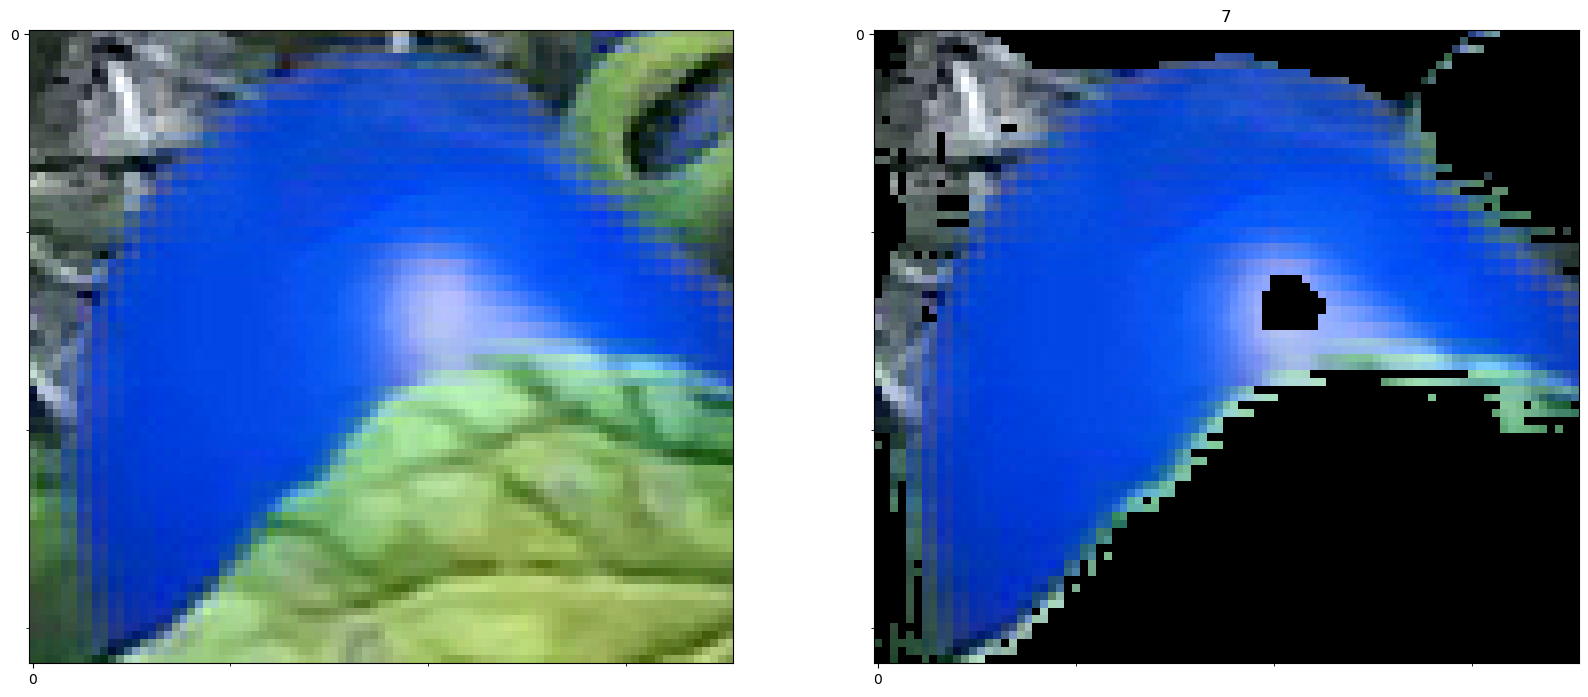

/tmp/ipykernel_10834/290486816.py:72: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_10834/290486816.py:73: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_10834/290486816.py:74: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 47.19367903419353 2.0148126375182374 48.9363156257305 1.5540777390956821 
 pix med: 
 55.12829870598482 2.240844333354809 57.18929301597479 2.3618177980588446 
 margin 0.2: 
 46.14453456468053 1.2690108726675318 44.12289592954848 1.5838948518738452 
 margin 0.5: 
 45.94787102606561 1.2967875782649234 44.121372285816406 1.5804794969524647 
 margin 0.8: 
 45.69223837720023 1.3111725660364155 44.134450455506645 1.5865926281254847 
 margin_f0.2: 
 45.8853037820922 1.3992621673333994 47.633318354686104 3.748632423026332 
 margin 0.5_f: 
 45.755822045935524 1.3784243555923812 41.8779673675696 3.4273026457390205 
 margin 0.8_f: 
 45.549763242403664 1.4329015402822958 33.73790039784379 5.478845386586055


  4%|██████▋                                                                                                                                                                                    | 5/139 [00:00<00:24,  5.50it/s]/tmp/ipykernel_10834/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
  6%|████████████                                                                                                                                                                               | 9/139 [00:01<00:20,  6.27it/s]/tmp/ipykernel_10834/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:21<00:00,  6.32it/s]


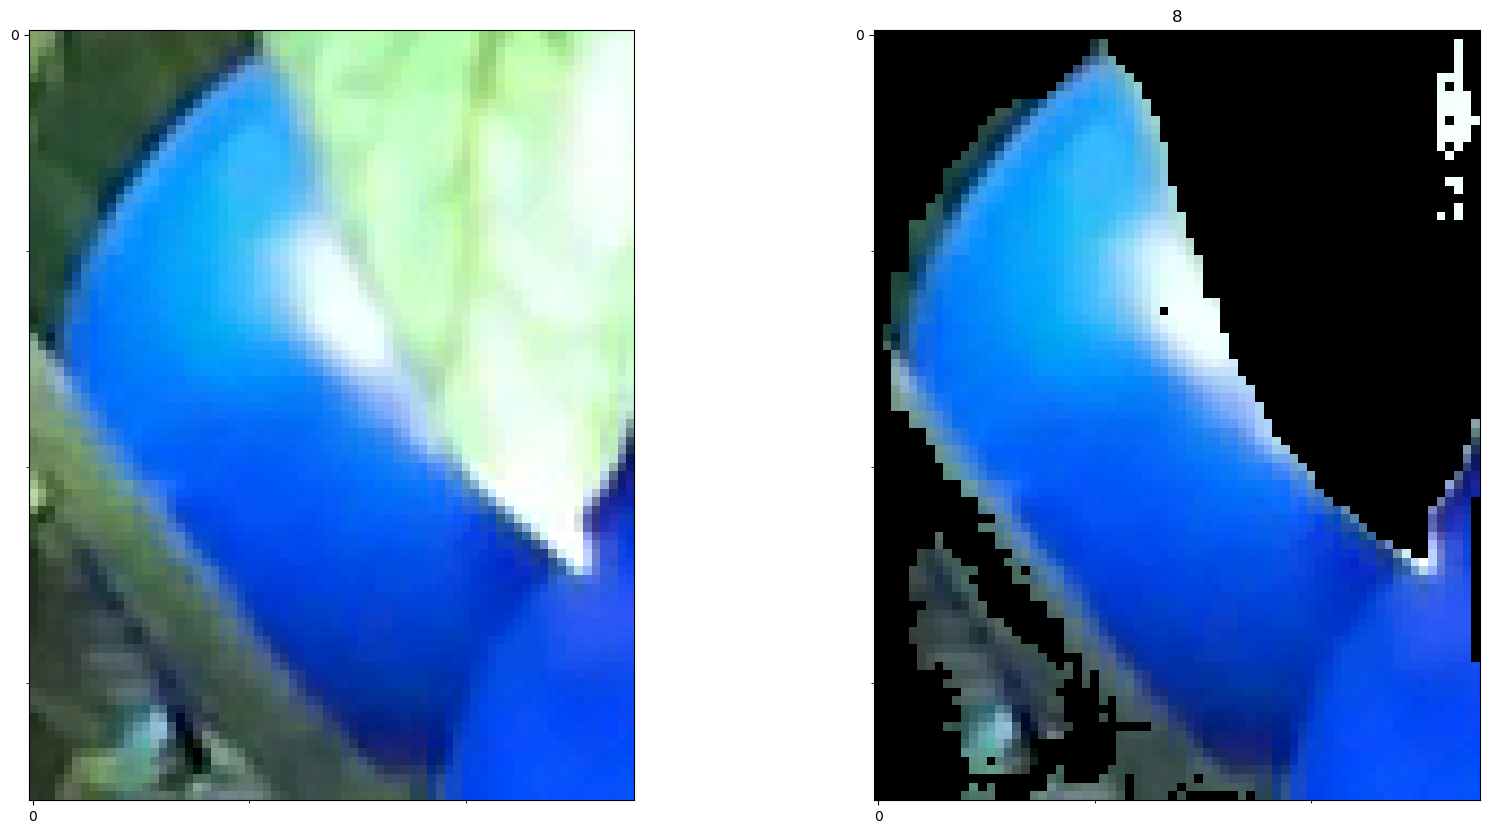

/tmp/ipykernel_10834/290486816.py:72: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_10834/290486816.py:73: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_10834/290486816.py:74: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 50.44327526909545 1.5304223212543155 41.21962632308695 1.6994677877747415 
 pix med: 
 58.97582660629712 1.637296742976805 48.19230824027323 1.9165605601205205 
 margin 0.2: 
 36.459634335135384 1.5878225026299762 46.27398589103342 2.318531256779555 
 margin 0.5: 
 36.36684298193712 1.7094425138877178 44.25951750051203 2.061427999074969 
 margin 0.8: 
 36.051278438070696 2.019598759753776 40.32687505157731 2.046436415465431 
 margin_f0.2: 
 38.735147565603256 1.9661725583142824 46.3660099952341 3.0768263873874573 
 margin 0.5_f: 
 38.095847710216646 1.8898672790682043 45.888744241042104 2.936488375120475 
 margin 0.8_f: 
 37.67587336972892 1.8037981678062802 41.85929007345824 3.796431210327022


  0%|                                                                                                                                                                                                   | 0/107 [00:00<?, ?it/s]/tmp/ipykernel_10834/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
/tmp/ipykernel_10834/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:16<00:00,  6.58it/s]


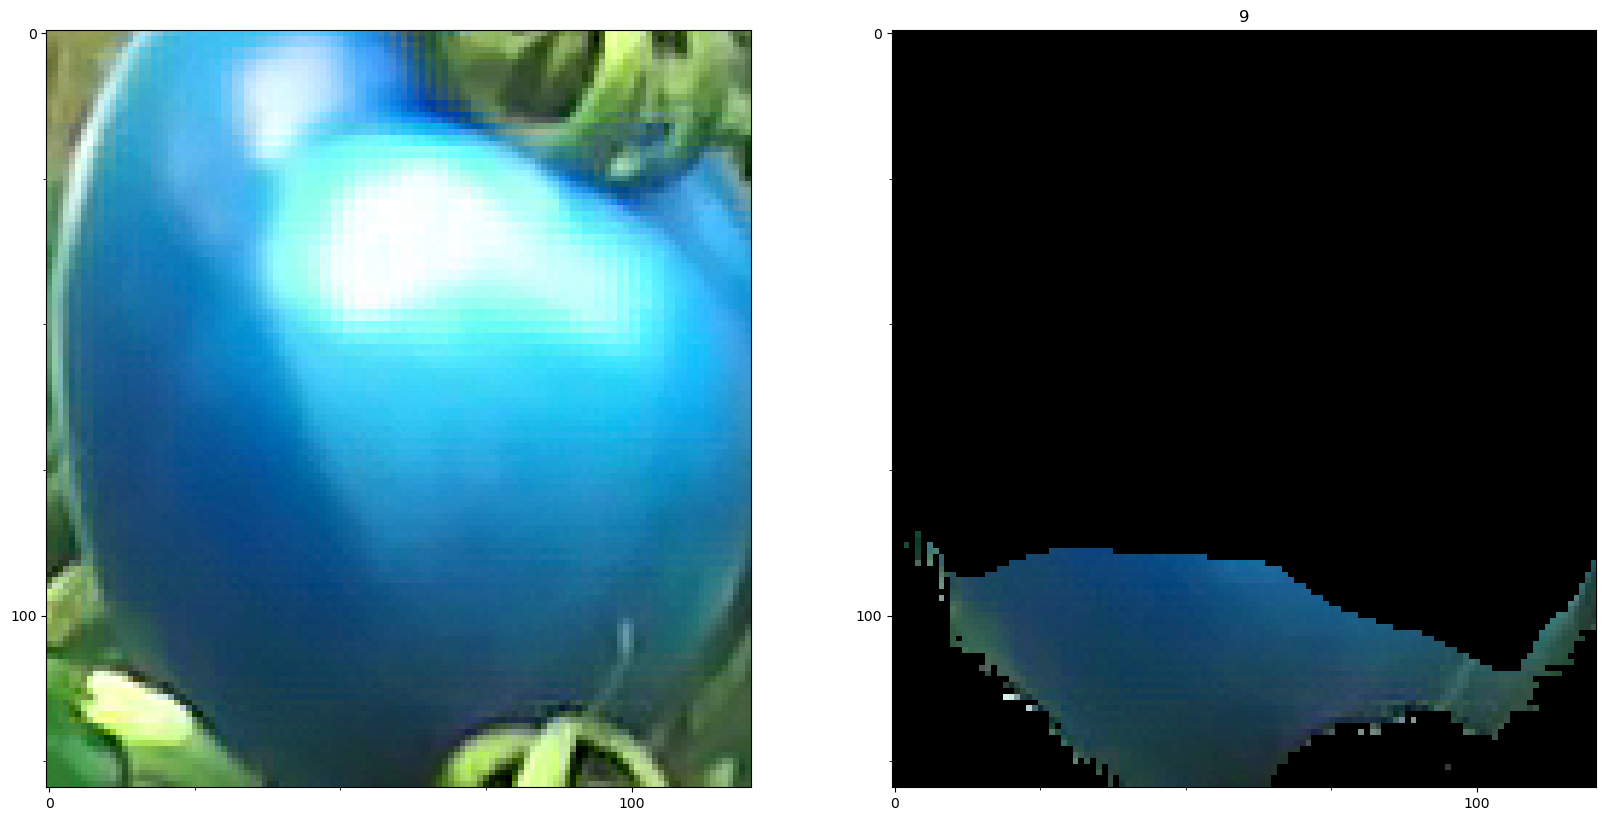

/tmp/ipykernel_10834/290486816.py:72: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_10834/290486816.py:73: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_10834/290486816.py:74: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 74.65252416362708 2.5152790968038423 71.42917299642188 3.08756164568366 
 pix med: 
 87.4159491987176 3.2280572503200964 83.6136054758558 3.158475778299179 
 margin 0.2: 
 117.99285999525374 38.46631857864179 161.0862715082748 88.172281789695 
 margin 0.5: 
 147.78078598118273 66.96267618187228 182.11672267067098 109.48086312630605 
 margin 0.8: 
 229.76460687599135 93.67570222281442 195.4934645061181 113.46158009722537 
 margin_f0.2: 
 134.55324459855802 42.19225439823761 135.8151114154085 76.32131117746175 
 margin 0.5_f: 
 143.1913081345693 43.22279351389634 140.42590011920885 78.70581322789778 
 margin 0.8_f: 
 166.90674082686505 62.362543316636994 143.98437459892202 76.9941574622035


  0%|                                                                                                                                                                                                   | 0/146 [00:00<?, ?it/s]/tmp/ipykernel_10834/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
/tmp/ipykernel_10834/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:21<00:00,  6.89it/s]


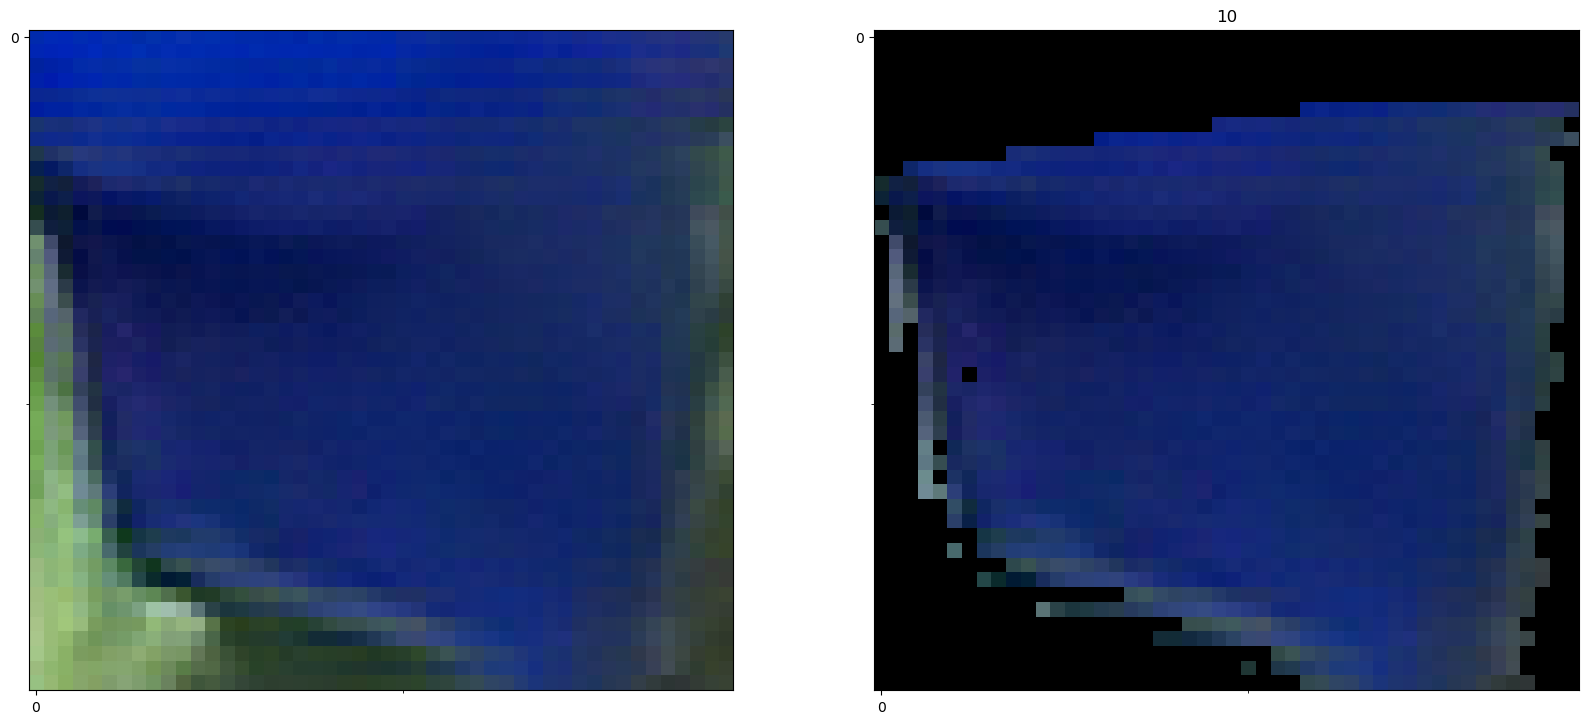

/tmp/ipykernel_10834/290486816.py:72: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_10834/290486816.py:73: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_10834/290486816.py:74: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 24.178087552899356 1.6810461374929955 27.02363264779275 1.34710557621753 
 pix med: 
 28.302794518112535 2.301921978589878 31.62348822558438 1.8924281297292043 
 margin 0.2: 
 27.241750326875138 2.0860950524621265 24.83556803622066 2.124033547479205 
 margin 0.5: 
 27.18271199001433 2.0501422564944956 25.03910531889494 2.1243170045342006 
 margin 0.8: 
 27.126038077044978 2.0018218383233757 25.10077841835071 2.0997292819103937 
 margin_f0.2: 
 26.774435061706257 2.181330013245456 25.106191749952426 3.047377122908675 
 margin 0.5_f: 
 26.834985190262532 2.104306252360161 24.544328157726216 2.7281395117153413 
 margin 0.8_f: 
 24.869305273033167 1.9875631849651112 22.81873277707459 1.9228519027828088


  0%|                                                                                                                                                                                                    | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_10834/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
 15%|████████████████████████████▏                                                                                                                                                               | 6/40 [00:00<00:05,  6.43it/s]/tmp/ipykernel_10834/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.41it/s]


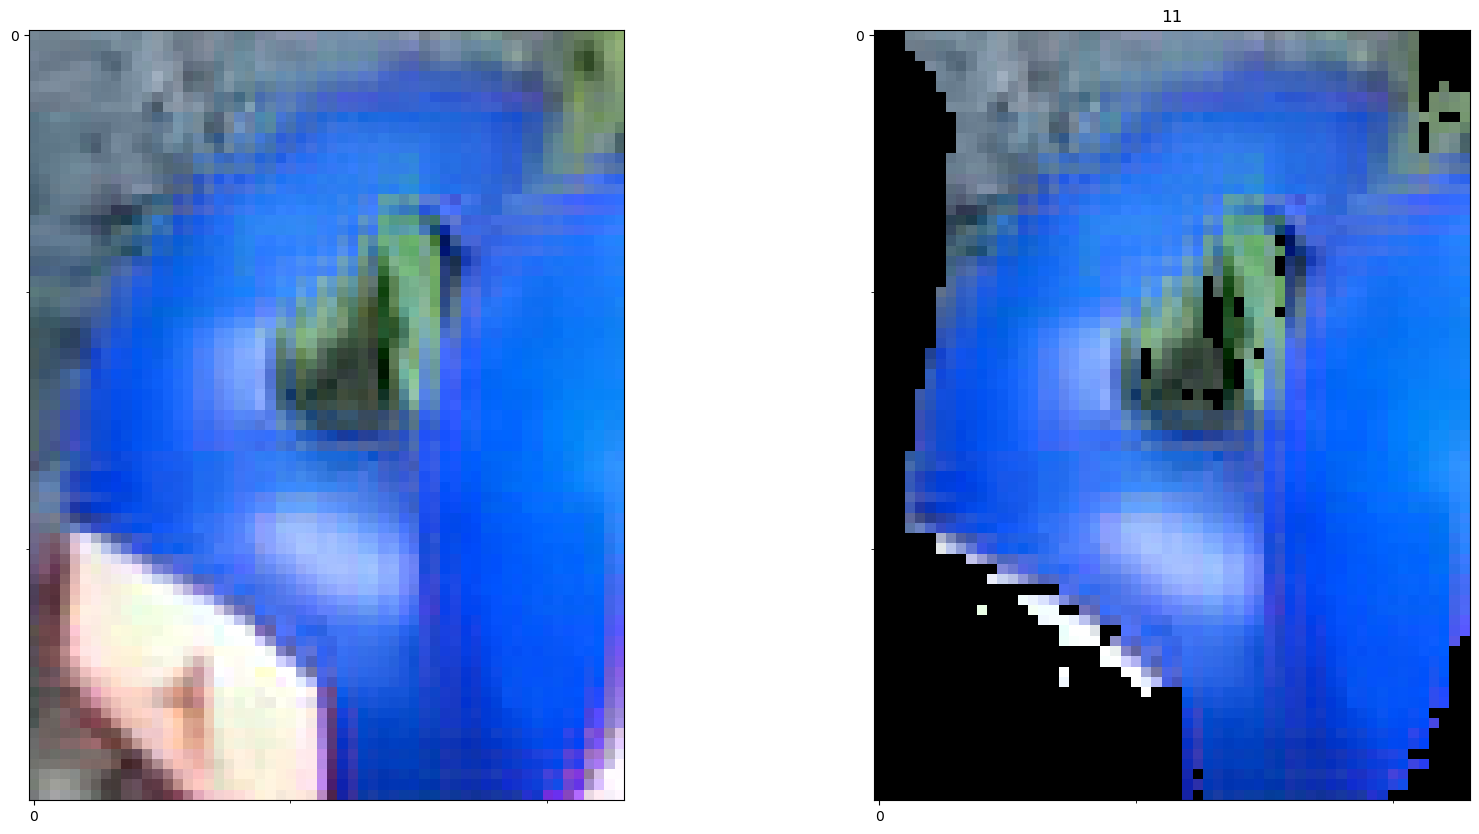

/tmp/ipykernel_10834/290486816.py:72: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_10834/290486816.py:73: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_10834/290486816.py:74: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 41.5255434198322 3.3714738110037397 32.44289906788312 1.6889425369708602 
 pix med: 
 48.57873763538002 3.854024023959239 37.956551159667086 1.8980542053666154 
 margin 0.2: 
 122.70831800997257 26.433114888580736 79.65431865304708 33.96202947869099 
 margin 0.5: 
 125.82550439983606 23.516920526502897 86.91047048196197 37.805098045135 
 margin 0.8: 
 133.17486941814423 16.649827869670197 90.44134011492133 39.46423413161964 
 margin_f0.2: 
 94.73252035677433 17.8724844011663 73.35387375205755 26.928548886754598 
 margin 0.5_f: 
 96.70399092137814 14.65153397933823 77.75380043312907 27.137245021640066 
 margin 0.8_f: 
 100.80842655152082 13.492737287608351 82.94151183217764 30.516095766521506


  0%|                                                                                                                                                                                                    | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_10834/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 7/11 [00:01<00:00,  5.81it/s]/tmp/ipykernel_10834/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  5.60it/s]


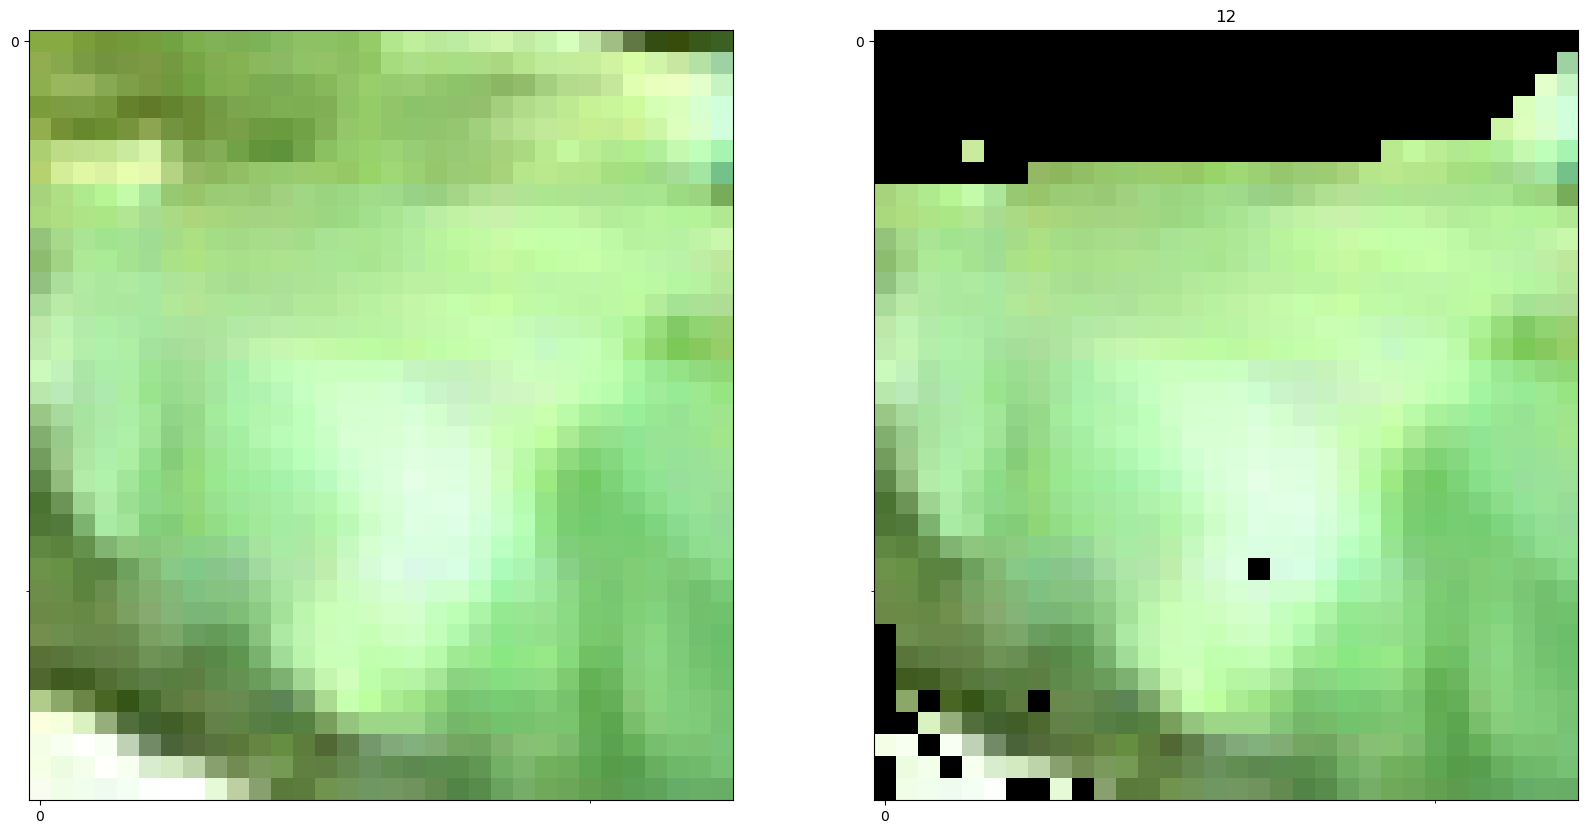

/tmp/ipykernel_10834/290486816.py:72: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_10834/290486816.py:73: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_10834/290486816.py:74: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 20.084550744382877 0.5016351501715448 19.670539056109913 0.5186092360338108 
 pix med: 
 23.328761283075313 0.6758702511714877 22.841185328167914 0.4205805226629952 
 margin 0.2: 
 22.531331093473867 0.8111000334831762 27.570010078224268 1.0822236074731357 
 margin 0.5: 
 22.921245714480225 1.2896027070299663 26.921904730525885 1.2856122590172867 
 margin 0.8: 
 23.995537141507324 2.554786031553962 27.391978454860773 1.3694095394478867 
 margin_f0.2: 
 22.524643858725373 0.9618029022669502 26.738335632465102 1.4003747182341022 
 margin 0.5_f: 
 21.972043439745903 0.7142165737124138 25.64189024269581 2.1473719628369867 
 margin 0.8_f: 
 21.52403901246461 0.708554073508044 25.588103316046976 2.7592307901861837


  0%|                                                                                                                                                                                                    | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_10834/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
 50%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 8/16 [00:01<00:01,  6.96it/s]/tmp/ipykernel_10834/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


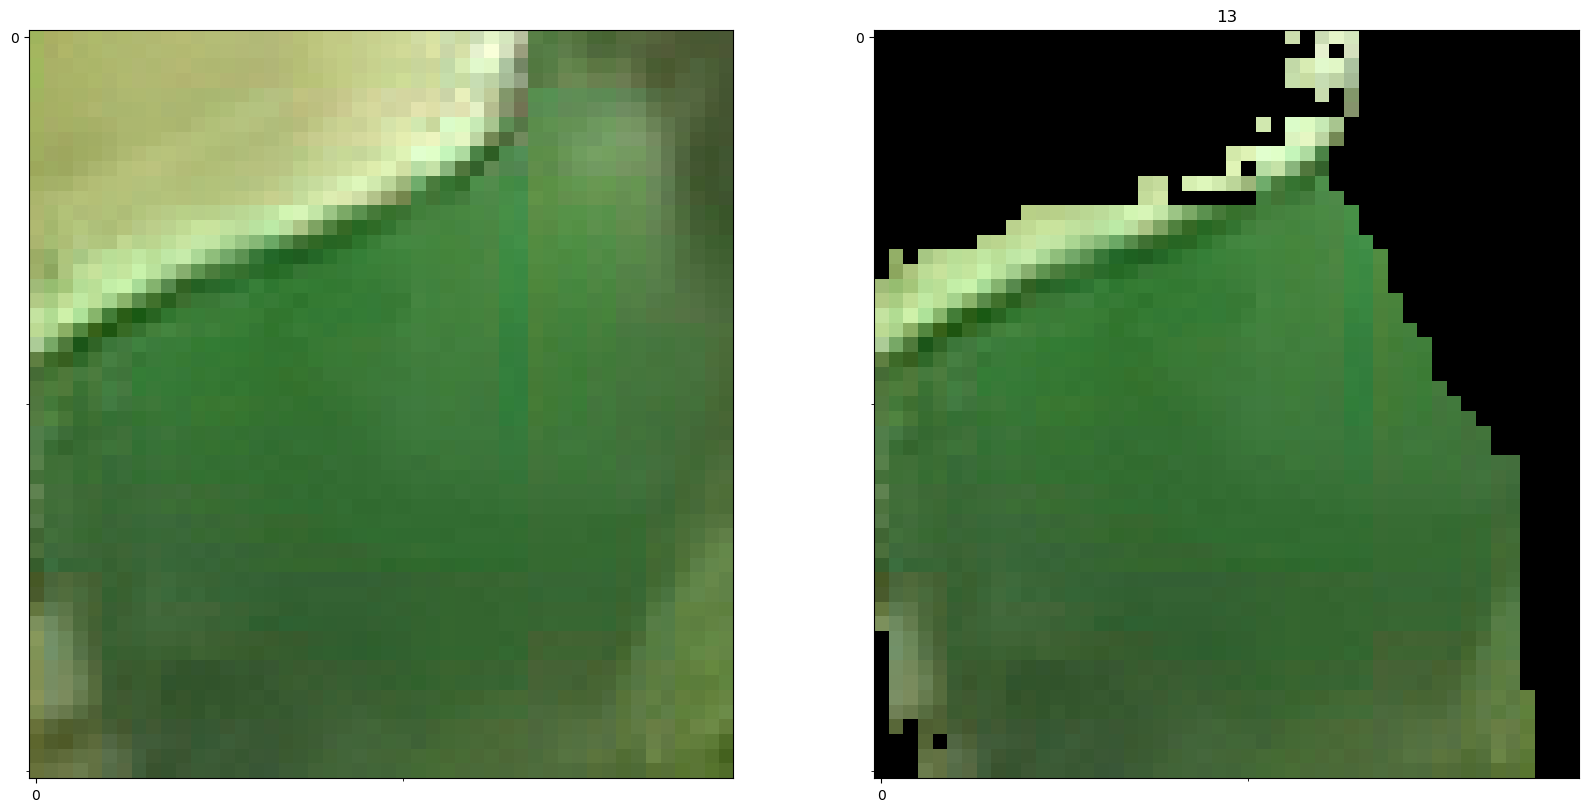

/tmp/ipykernel_10834/290486816.py:72: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_10834/290486816.py:73: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_10834/290486816.py:74: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 27.648698337915846 2.1847520349310217 23.92566533685027 0.5610426410231749 
 pix med: 
 32.41487726880473 2.257995439507134 28.077231826219524 0.9219015517859461 
 margin 0.2: 
 34.33555061928928 1.418657808410249 27.63727051205933 1.8032133360357991 
 margin 0.5: 
 34.33768660761416 1.608514892766771 26.953126885928214 2.2853065279759845 
 margin 0.8: 
 33.75072928611189 2.439020198298828 26.368863880634308 2.906425300759714 
 margin_f0.2: 
 30.70373833179474 2.2797285543930803 26.733952458016574 2.9103476676102695 
 margin 0.5_f: 
 31.01357992272824 2.8014477819729486 26.400662143714726 3.0227086788734967 
 margin 0.8_f: 
 30.275974539108574 2.3381670502039116 24.968588608317077 3.963932919343146


  0%|                                                                                                                                                                                                   | 0/153 [00:00<?, ?it/s]/tmp/ipykernel_10834/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
/tmp/ipykernel_10834/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 120/153 [00:17<00:05,  5.97it/s]

In [ ]:
# for track_id in [6,7,12,28]:
for track_id in range(30):
    cam = video_wrapper(args.movie_path, args.rotate, args.depth_minimum, args.depth_maximum)
    frame_numbers = get_track_id_frames(measures_frame, track_id)
    boxes = get_track_id_boxes(measures_frame, track_id)
    ellps_w, ellps_h, ellps_z = [], [], []
    pix_size_w_mean, pix_size_h_mean = [], []
    pix_size_w_med, pix_size_h_med = [], []
    margin_h_2, margin_w_2 = [], []
    margin_h_5, margin_w_5 = [], []
    margin_h_8, margin_w_8 = [], []
    margin_h_2_f, margin_w_2_f = [], []
    margin_h_5_f, margin_w_5_f = [], []
    margin_h_8_f, margin_w_8_f = [], []
    for i in tqdm(range(len(frame_numbers))):
        frame, box = frame_numbers[i], boxes[i]
        rgb_img, _, pc_img = cam.get_zed(frame)
        x1,y1,x2,y2 = validate_bbox(box, rgb_img)
        pc_crop = pc_img[y1:y2, x1:x2,:3]
        rgb_crop = rgb_img[y1:y2, x1:x2]
#         filtered_center = kde_filtering(pc_crop[:,:,:3].reshape(-1,3))
#         _, width, height, z_w = ellipsoid_fit_ransac(filtered_center)
#         if width > 200 or height > 200 or z_w > 200: #if fruits are too big its probably due to noise
#             width, height, z_w = np.nan, np.nan, np.nan
#         ellps_w.append(width*100), ellps_h.append(height*100), ellps_z.append(z_w*100)
        width, height = get_dims_w_pixel_size(pc_img, [x1,y1,x2,y2], "mean")
        pix_size_w_mean.append(width*100), pix_size_h_mean.append(height*100)
        width, height = get_dims_w_pixel_size(pc_img, [x1,y1,x2,y2], "median")
        pix_size_w_med.append(width*100), pix_size_h_med.append(height*100)
        

        width = get_width(pc_crop, 0.2, fixed_z=True, max_z=1)
        height = get_height(pc_crop, 0.2, fixed_z=True, max_z=1)
        margin_h_2.append(height)
        margin_w_2.append(width)
        
        width = get_width(pc_crop, 0.5, fixed_z=True, max_z=1)
        height = get_height(pc_crop, 0.5, fixed_z=True, max_z=1)
        margin_h_5.append(height)
        margin_w_5.append(width)
        
        width = get_width(pc_crop, 0.8, fixed_z=True, max_z=1)
        height = get_height(pc_crop, 0.8, fixed_z=True, max_z=1)
        margin_h_8.append(height)
        margin_w_8.append(width)
        
        pc_crop_f = pc_crop.copy()
        rgb_crop_c = rgb_crop.copy()
        filter_vec = hue_filtering(rgb_crop, nstds = 1.5)
        rgb_crop_c[filter_vec] = 0
        pc_crop_f[filter_vec] = np.nan
        filter_vec = np.isnan(filter_xyz_outliers(pc_crop, 2, False))
        rgb_crop_c[filter_vec] = 0
        pc_crop_f[filter_vec] = np.nan
        
        width = get_width(pc_crop_f, 0.2, fixed_z=True, max_z=1)
        height = get_height(pc_crop_f, 0.2, fixed_z=True, max_z=1)
        margin_h_2_f.append(height)
        margin_w_2_f.append(width)
        
        width = get_width(pc_crop_f, 0.5, fixed_z=True, max_z=1)
        height = get_height(pc_crop_f, 0.5, fixed_z=True, max_z=1)
        margin_h_5_f.append(height)
        margin_w_5_f.append(width)
        
        width = get_width(pc_crop_f, 0.8, fixed_z=True, max_z=1)
        height = get_height(pc_crop_f, 0.8, fixed_z=True, max_z=1)
        margin_h_8_f.append(height)
        margin_w_8_f.append(width)

    plot_2_imgs(rgb_crop, rgb_crop_c, track_id)
    print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
          np.nanmean(ellps_h), np.nanstd(ellps_h),
          np.nanmean(ellps_z), np.nanstd(ellps_z),
          "\n pix mean: \n",
         np.nanmean(pix_size_w_mean), np.nanstd(pix_size_w_mean),
          np.nanmean(pix_size_h_mean), np.nanstd(pix_size_h_mean),
          "\n pix med: \n"
        ,np.nanmean(pix_size_w_med), np.nanstd(pix_size_w_med),
          np.nanmean(pix_size_h_med), np.nanstd(pix_size_h_med),
         "\n margin 0.2: \n", 
        np.nanmean(margin_w_2), np.nanstd(margin_w_2),
          np.nanmean(margin_h_2), np.nanstd(margin_h_2),
                  "\n margin 0.5: \n", 
        np.nanmean(margin_w_5), np.nanstd(margin_w_5),
          np.nanmean(margin_h_5), np.nanstd(margin_h_5),
                  "\n margin 0.8: \n", 
        np.nanmean(margin_w_8), np.nanstd(margin_w_8),
          np.nanmean(margin_h_8), np.nanstd(margin_h_8),
          
                  "\n margin_f0.2: \n", 
        np.nanmean(margin_w_2_f), np.nanstd(margin_w_2_f),
          np.nanmean(margin_h_2_f), np.nanstd(margin_h_2_f),
                  "\n margin 0.5_f: \n", 
        np.nanmean(margin_w_5_f), np.nanstd(margin_w_5_f),
          np.nanmean(margin_h_5_f), np.nanstd(margin_h_5_f),
                  "\n margin 0.8_f: \n", 
        np.nanmean(margin_w_8_f), np.nanstd(margin_w_8_f),
          np.nanmean(margin_h_8_f), np.nanstd(margin_h_8_f))

In [ ]:
    print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
          np.nanmean(ellps_h), np.nanstd(ellps_h),
          np.nanmean(ellps_z), np.nanstd(ellps_z),
          "\n pix mean: \n",
         np.nanmean(pix_size_w_mean), np.nanstd(pix_size_w_mean),
          np.nanmean(pix_size_h_mean), np.nanstd(pix_size_h_mean),
          "\n pix med: \n"
        ,np.nanmean(pix_size_w_med), np.nanstd(pix_size_w_med),
          np.nanmean(pix_size_h_med), np.nanstd(pix_size_h_med),
         "\n margin 0.2: \n", 
        np.nanmean(margin_w_2), np.nanstd(margin_w_2),
          np.nanmean(margin_h_2), np.nanstd(margin_h_2),
                  "\n margin 0.5: \n", 
        np.nanmean(margin_w_5), np.nanstd(margin_w_5),
          np.nanmean(margin_h_5), np.nanstd(margin_h_5),
                  "\n margin 0.8: \n", 
        np.nanmean(margin_w_8), np.nanstd(margin_w_8),
          np.nanmean(margin_h_8), np.nanstd(margin_h_8))

In [ ]:
track_id = 5
cam = video_wrapper(args.movie_path, args.rotate, args.depth_minimum, args.depth_maximum)
frame_numbers = get_track_id_frames(measures_frame, track_id)
boxes = get_track_id_boxes(measures_frame, track_id)
ellps_w, ellps_h, ellps_z = [], [], []
pix_size_w_mean, pix_size_h_mean = [], []
pix_size_w_med, pix_size_h_med = [], []
i = len(frame_numbers) -1
frame, box = frame_numbers[i], boxes[i]
rgb_img, _, pc_img = cam.get_zed(frame)
x1,y1,x2,y2 = validate_bbox(box, rgb_img)
pc_crop = pc_img[y1:y2, x1:x2,:3]
plt.imshow(rgb_img[y1:y2, x1:x2])
plt.title(track_id)
plt.show()

In [ ]:
cut_box_pc = cut_center_of_box(pc_crop, 0.1)
cut_box_rgb = cut_center_of_box(rgb_img[y1:y2, x1:x2], 0.1)
plot_2_imgs(cut_box_pc[:, :, 2], cut_box_rgb)

In [ ]:
def apply_sobol(det_crop, plot_change=False):
    """
    applies sobol filterning on image
    :param det_crop: image to apply filter on
    :param plot_change: flag to show the image after applying sobol
    :return: image after sobol filtering
    """
    torch_img = K.utils.image_to_tensor(det_crop)
    torch_img = torch_img[None, ...].float() / 255.
    torch_img = K.enhance.adjust_contrast(torch_img, 0.5)
    torch_img_gray = K.color.rgb_to_grayscale(torch_img)
    processed_img = K.filters.sobel(torch_img_gray, True, 1e-3) 
    if plot_change:
        plot_2_imgs(det_crop, processed_img.detach().numpy()[0, 0] > 0.05)
    return processed_img.detach().numpy()[0, 0]
out_img = apply_sobol(rgb_img[y1:y2, x1:x2], True)

In [ ]:
min_area = 5
out_img = out_img > 0.04
rgb_crop = rgb_img[y1:y2, x1:x2].copy()
contours, _ = cv2.findContours(out_img.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

filtered_contours = []
for c in contours:
    if cv2.contourArea(c) >= min_area:
        filtered_contours.append(c)

mask = np.zeros_like(out_img).astype(np.uint8)
hull = cv2.convexHull(np.concatenate(filtered_contours))
cv2.drawContours(mask, [hull], 0, (255, 255, 255), -1)
plot_2_imgs(out_img, mask)

rgb_c = rgb_crop.copy()
rgb_c[np.logical_not(mask)] = 0
plot_2_imgs(rgb_crop, rgb_c)

In [ ]:
def hue_filtering(rgb_crop, nstds = 1):
    rgb_c = rgb_crop.copy()
    hsv = cv2.cvtColor(rgb_c, cv2.COLOR_BGR2HSV)
    hue, sat, v = cv2.split(hsv.copy())
    hist_vals, hist_bins = np.histogram(hue, bins = 50)
    mode = hist_bins[np.argmax(hist_vals)]
    hue_std = np.std(hue)
    upper_limit = mode + nstds*hue_std
    lower_limit = mode - nstds*hue_std
    logical_vec = np.any([hue > upper_limit, hue < lower_limit], axis = 0)
    rgb_c[logical_vec] = 0
    return rgb_c
plot_2_imgs(rgb_crop, hue_filtering(rgb_crop))

In [ ]:
# rgb_images, pc_images = get_track_id_images(measures_frame, 0, args)
# hue_filtered = [hue_filtering(rgb_c) for rgb_c in rgb_images]
# plot_image_grid(hue_filtered, 5, np.ceil(hue_filtered/5))

In [ ]:
plt.imshow(rgb_c)

In [ ]:
hist_bins[np.argmax(hist_vals)] + 1*np.std(hue)

In [ ]:
hsv = cv2.cvtColor(rgb_c, cv2.COLOR_BGR2HSV)
hue, sat, v = cv2.split(hsv.copy())
rgb_crop = rgb_c.copy()
plot_2_imgs(rgb_c, hue)
rgb_crop[hue > 200] = 0
plot_2_imgs(rgb_c, rgb_crop)
rgb_crop[hue > 150] = 0
plot_2_imgs(rgb_c, rgb_crop)
rgb_crop[hue > 100] = 0
plot_2_imgs(rgb_c, rgb_crop)
rgb_crop[hue > 50] = 0
plot_2_imgs(rgb_c, rgb_crop)
rgb_crop[hue > 25] = 0
plot_2_imgs(rgb_c, rgb_crop)

In [ ]:
d2_border_points = np.where(out_img> 0.05)
spX=d2_border_points[0]
spY=d2_border_points[1]

A = np.zeros((len(spX),3))
A[:,0] = spX*2
A[:,1] = spY*2
A[:,2] = 1

#   Assemble the f matrix
f = np.zeros((len(spX),1))
f[:,0] = (spX*spX) + (spY*spY)
C, residules, rank, singval = np.linalg.lstsq(A,f)
C = np.abs(C)
#   solve for the radius
t = (C[0]*C[0])+(C[1]*C[1])+C[2]
radius = np.sqrt(t)/2
# channels are switched
radius, np.sqrt(C[1]), np.sqrt(C[0])

In [ ]:
radius[0]**2 - x**2

In [ ]:
circle_img = np.full(out_img.shape,0)
for x in range(out_img.shape[1]):
    y = int(np.sqrt(np.abs(radius[0]**2 - (x+C[0][0])**2)) + C[1][0])
    if y < out_img.shape[0]:
        circle_img[x,y] = 1
plt.imshow(circle_img)
plt.show()

In [ ]:
stop

In [ ]:
rgb_images, pc_images = get_track_id_images(measures_frame, 5, args)

In [ ]:
w = []
h = []
for track_id in range(len(pc_images)):
    pc_img = pc_images[track_id]
    box = get_track_id_boxes(measures_frame, 5)[track_id]
    wid,hei = get_dims_w_pixel_size(pc_img, box, "mean")
    w.append(wid), h.append(hei)
np.mean(w), np.mean(h), np.std(w), np.std(h)

In [ ]:
pc_images[-1][30,:,0]

In [ ]:
pc_images[-1][30,:,1]

In [ ]:
arr = pc_images[-1][30,:,2].flatten()
sns.kdeplot(arr)
plt.vlines(np.nanmedian(arr), 0,17.5,color = "black")
plt.vlines(np.nanmedian(arr) + 2*arr.std(),0,17.5,color = "green")

In [ ]:
centers = pc_images[-1][:,:,:3].reshape(-1,3)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(-centers[:, 2], -centers[:, 0], -centers[:, 1])
# for i, label in enumerate(fruit_3d_space.keys()):
#     ax.text(-centers[i, 2], -centers[i, 0], -centers[i, 1], '%s' % (str(label)), size=10, zorder=1,
#             color='k')
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.view_init(0,15)
plt.show()

In [ ]:
import numpy as np
from scipy import stats
def measure(n):
    "Measurement model, return two coupled measurements."
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1+m2, m1-m2
m1, m2 = measure(2000)
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
values.shape

In [ ]:
values

In [ ]:
finite_centers = centers[np.all(np.isfinite(centers),axis = 1)]
kernel = gaussian_kde(finite_centers.T)

In [ ]:
plt.hist(kernel(finite_centers.T)/np.sum(kernel(finite_centers.T)))

In [ ]:
0.0001*len(finite_centers)

In [ ]:
for i in range(len(rgb_images)):
    rgb_img = rgb_images[i]
    # plt.imshow(rgb_img)
    centers = pc_images[i][:,:,:3].reshape(-1,3)
    filtered_center = kde_filtering(centers)
    # max_z = min(np.abs(np.nanmedian(centers[:,2]) + 2 * np.nanstd(centers[:,2])),1.1)
    # filtered_center[np.abs(centers[:,2]) > max_z] = np.nan
    # filtered_center[np.abs(centers[:,1]) > np.abs(np.nanmedian(centers[:,1]) + 2 * np.nanstd(centers[:,1]))] = np.nan
    # filtered_center[np.abs(centers[:,0]) > np.abs(np.nanmedian(centers[:,0]) + 2* np.nanstd(centers[:,0]))] = np.nan
    filtere_rgb = rgb_img.copy()
    filtere_rgb[np.isnan(filtered_center.reshape(rgb_img.shape))] = 0
    plot_2_imgs(rgb_img, filtere_rgb)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
rgb_img = rgb_images[-4]
# plt.imshow(rgb_img)
centers = pc_images[-4][:,:,:3].reshape(-1,3)
finite_centers = centers[np.all(np.isfinite(centers),axis = 1)].copy()
kernel = gaussian_kde(finite_centers.T)
points_density = np.array([])
for point in centers:
    if not np.sum(np.isnan(point)):
        points_density = np.append(points_density, kernel(point))
    else:
        points_density = np.append(points_density, np.nan)

points_density = points_density/np.nansum(points_density)
filtered_center = finite_centers.copy()
filtered_center[points_density <0.5/ len(finite_centers)] = np.nan
# max_z = min(np.abs(np.nanmedian(centers[:,2]) + 2 * np.nanstd(centers[:,2])),1.1)
# filtered_center[np.abs(centers[:,2]) > max_z] = np.nan
# filtered_center[np.abs(centers[:,1]) > np.abs(np.nanmedian(centers[:,1]) + 2 * np.nanstd(centers[:,1]))] = np.nan
# filtered_center[np.abs(centers[:,0]) > np.abs(np.nanmedian(centers[:,0]) + 2* np.nanstd(centers[:,0]))] = np.nan
filtere_rgb = rgb_img.copy()
filtere_rgb[np.isnan(filtered_center.reshape(rgb_img.shape))] = 0
plot_2_imgs(rgb_img, filtere_rgb)
def plot_3d_scatter(angle1, angle2, angle3):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.scatter3D(-filtered_center[:, 2], -filtered_center[:, 1], -filtered_center[:, 0],s = 1)
    ax.set_xlabel('z')
    ax.set_ylabel('x')
    ax.set_zlabel('y')
    ax.view_init(angle1, angle2, angle3)
    plt.show()
    
# define the sliders for the viewing angles
angle1_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=0)
angle2_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=0)
angle3_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=0)

# create the interactive plot
interactive_plot = interact(plot_3d_scatter, angle1=angle1_slider, angle2=angle2_slider, angle3 = angle3_slider)

# display the interactive plot
display(interactive_plot)


In [ ]:
import math
def ellipsoid_fit(filtered_center):
    spX=filtered_center[:,0]
    spY=filtered_center[:,1]
    spZ=filtered_center[:,2]
    falut_rows = np.any(np.isnan(np.column_stack([spX,spY,spZ])), axis=1)
    spX,spY,spZ = spX[~falut_rows],spY[~falut_rows],spZ[~falut_rows]

    A = np.zeros((len(spX),4))
    A[:,0] = spX*2
    A[:,1] = spY*2
    A[:,2] = spZ*2
    A[:,3] = 1

    #   Assemble the f matrix
    f = np.zeros((len(spX),1))
    f[:,0] = (spX*spX) + (spY*spY) + (spZ*spZ)
    C, residules, rank, singval = np.linalg.lstsq(A,f)
    C = np.abs(C)
    #   solve for the radius
    t = (C[0]*C[0])+(C[1]*C[1])+(C[2]*C[2])+C[3]
    radius = np.sqrt(t)
    # channels are switched
    return radius, np.sqrt(C[1]), np.sqrt(C[0]), np.sqrt(C[2])

rgb_img = rgb_images[-1]
plt.imshow(rgb_img)
plt.show()
r = []
w = []
h = []
z = []
for i in range(len(pc_images)):
    centers = pc_images[i][:,:,:3].reshape(-1,3)
    filtered_center = centers.copy()
    filtered_center[np.abs(centers[:,2]) > np.abs(np.nanmedian(centers[:,2]) + 2 * np.nanstd(centers[:,2]))] = np.nan
    filtered_center[np.abs(centers[:,1]) > np.abs(np.nanmedian(centers[:,1]) + 2 * np.nanstd(centers[:,1]))] = np.nan
    filtered_center[np.abs(centers[:,0]) > np.abs(np.nanmedian(centers[:,0]) + 2* np.nanstd(centers[:,0]))] = np.nan
    r_t, w_t, h_t, z_t = ellipsoid_fit(filtered_center)
    r.append(r_t)
    w.append(w_t)
    h.append(h_t)
    z.append(z_t)
np.mean(r), np.mean(w),np.mean(h),np.mean(z)

In [ ]:
np.std(r), np.std(w),np.std(h)

In [ ]:
x,y,z = filtered_center[:,1][~falut_rows],filtered_center[:,0][~falut_rows],filtered_center[:,2][~falut_rows]
A = np.array([x**2, y**2, z**2]).T

# vector of ones
O = np.ones(len(x))

# least squares solver
B, resids, rank, s = np.linalg.lstsq(A, O)

# solving for a, b, c
a_ls = np.sqrt(1.0/B[0])
b_ls = np.sqrt(1.0/B[1])
c_ls = np.sqrt(1.0/B[2])
a_ls, b_ls, c_ls